## **Nike Amazon Product Reviews Analytics and Topic Modeling** - **DSTA 5799 Final Proj**

# **Project Introduction and Goal**:
This is the final project for MSDS DSTA 5799. For this project, I will analyze and use **topic modeling** to deliver marketing and product insights for a popular clothing and/or shoe company, Nike.

I'll mainly use [**tmtoolkit** module](https://tmtoolkit.readthedocs.io/en/latest/getting_started.html) for text pre-processing, dtm, visualization, corpus management, topic modeling:



I may also use [**TextBolb** module](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis) for some light text analysis.



**⚡️ Important:** Beware of sentiment fuzziness: Like most machine-learning approaches, TextBlob's sentiment analysis is probabilistic -- results will sometimes not match your expectations.

**🙂 Project Slide** I did a [slide](https://docs.google.com/presentation/d/1M1rmaHsY0ygL2pdu8LXwTCThZrZYX-KGjxggSEtREM8/edit#slide=id.gc6f980f91_0_42) to present this project. It will be good to look to get a project overview.

# **Amazon Data:**
Prof. Julian McAuley at UC-San Diego has graciously let me use his “
[**Amazon** Product Data](http://jmcauley.ucsd.edu/data/amazon/links.html)
” database. It contains tons of data about **Amazon products**. Specifically, we will leverage two datasets: (1) meta-data about products and (2) product reviews. The aforementioned database has reviews on all types of Amazon products, but these datasets are huge (~80gb).

I’ve picked two smaller datasets that only contain products that are categorized as “**Clothing, Shoes & Jewelry**”:

 - (1) **meta-data** about products
 - (2) **reviews about products**

The product data:

http://128.138.93.164/meta_Clothing_Shoes_and_Jewelry.json.gz

The review data here:

http://128.138.93.164/reviews_Clothing_Shoes_and_Jewelry.json.gz

*I’m using his original data release, but if you’re interested, there’s newer (2018ish) data that was just released.


## Installs and Imports

In [ ]:
!pip uninstall -y scipy
!pip install scipy==1.9.0

Found existing installation: scipy 1.9.0
Uninstalling scipy-1.9.0:
  Successfully uninstalled scipy-1.9.0
  Using cached scipy-1.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.2 kB)
Using cached scipy-1.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.14 requires scipy>=1.10.0, but you have scipy 1.9.0 which is incompatible.


In [ ]:
import os

try:
  from bertopic import BERTopic
except:
  !pip install bertopic[all]
  os.kill(os.getpid(), 9)

In [ ]:
# Install (and import) libraries
import os
try:
  import tmtoolkit
except:
  !pip install -U "tmtoolkit[recommended]"
  import tmtoolkit

try:
  from tmtoolkit.topicmod.tm_lda import compute_models_parallel
except:
  !pip install tmtoolkit['lda']
  from tmtoolkit.topicmod.tm_lda import compute_models_parallel

try:
  from lda import LDA
except:
  !pip install lda
  from lda import LDA

try:
  import pyLDAvis
except:
  !pip install pyLDAvis
  import pyLDAvis


!pip uninstall -y numba
!pip uninstall -y tensorflow

!pip install --upgrade numba

Found existing installation: numba 0.60.0
Uninstalling numba-0.60.0:
  Successfully uninstalled numba-0.60.0
  Using cached numba-0.60.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.7 kB)
Using cached numba-0.60.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.7 MB)


In [ ]:
# import libraries
import gzip
import itertools
import json
import pickle
import scipy.sparse
import operator

import random
from copy import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
import nltk
from string import punctuation

from tmtoolkit.utils import enable_logging # Enable logging to see the progress of long-running operations
from tmtoolkit.corpus import Corpus, print_summary, corpus_add_tabular
from tmtoolkit.corpus import doc_tokens, tokens_table, vocabulary_counts, vocabulary_size, vocabulary
from tmtoolkit.corpus import to_lowercase, remove_punctuation, lemmatize, remove_chars,  filter_for_pos
from tmtoolkit.corpus import filter_clean_tokens, remove_common_tokens, remove_uncommon_tokens, dtm,  remove_tokens
from tmtoolkit.corpus import corpus_num_tokens, corpus_tokens_flattened
from tmtoolkit.corpus import numbers_to_magnitudes
from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words
from tmtoolkit.topicmod.model_io import ldamodel_top_doc_topics, load_ldamodel_from_pickle, print_ldamodel_topic_words
from tmtoolkit.topicmod.model_io import save_ldamodel_to_pickle
from tmtoolkit.topicmod.visualize import parameters_for_ldavis
from tmtoolkit.corpus.visualize import plot_doc_lengths_hist, plot_ranked_vocab_counts
from tmtoolkit.topicmod.visualize import  plot_eval_results
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.topicmod import tm_lda
from tmtoolkit.topicmod.evaluate import results_by_parameter
# from tmtoolkit.corpus import remove_tokens


import logging
import warnings
enable_logging()

random.seed(20191120)   # to make the sampling reproducible
np.set_printoptions(precision=5)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Working Directory

In [ ]:
working_directory = '/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/2_topic_modeling/Final_proj'
gz_meta_path = "%s/meta_Clothing_Shoes_and_Jewelry.jsonl.gz" % working_directory
gz_review_path = "%s/reviews_Clothing_Shoes_and_Jewelry.json.gz" % working_directory
json_nikereview = "%s/allnikereviews.json" % working_directory
csv_nikereview = '%s/allnikereviews.csv' % working_directory


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


I'll use a generator to read files to avoid loading everything into memory at once.
For more information about generators, see the [Python wiki documentation on generators](https://wiki.python.org/moin/Generators) or this [generator tutorial from RealPython](https://realpython.com/introduction-to-python-generators/)


#**1. Get Nike ASINs and sales ranks of each ASIN products**

### The JSON-L data format

If you look directly in the data file, you will find that it is in a format of one product-per line. Each product is a json data structure. This is an unofficial data format commonly referred to as **JSON-L (the -L meaning per-line)**.

⚠️ Data format differs from the source data: the **metadata** is distributed as **lines of python code that need to be evaluated**. The file is in the **re-formatted json-l**.

### The product data structure

Looking at the individual lines, you would find a product data structure like the following example Nike product that has been formatted for easier reading:

```
{
    "asin": "B00APTJF6G",
    "related": {
        "also_bought": [ "B003JK5Y8G", "B00B2V1EEW" ],
        "also_viewed": [
            "B003JK5Y8G", "B00CB3259I", "B008QYSBRQ", "B00B2V1EEW", "B00E0WL76U",
            "B00CHQTGL4", "B00KQQ6HDW", "B008EMDAB2", "B008IBB2V4", "B00E0WKOAA",
            "B0052H0M9K", "B00HUXPAI2", "B00K5YT3KO", "B00CUQZYHG", "B00J8V3PDG",
            "B00APTKB5K", "B001GUSWJ4", "B00CM0COS2", "B00J2JODHQ", "B00E0NOFUO",
            "B00IDCBLXC", "B009IUDL0O", "B00JG6J2IA", "B00JJ6RCCK", "B008K6OIIG",
            "B00KHYBFPI", "B009O5KX7M", "B00GS1X0CK", "B00K0TM84M", "B00BYCCJSE",
            "B00DGCXOES", "B00DRMMYFW", "B00IURRG02", "B007T8HL9O", "B00FL837DI",
            "B006JRPQN4", "B008EMBHSA", "B00E3G4V02", "B004N6UVPG", "B00DU5UV60",
            "B00J8UU6MU", "B00EEC7OI6", "B00EDW2MG6", "B00IK609JI", "B008IB8TOM",
            "B00GN9V66Y", "B00KPZ6DSS", "B00HLMTTFM", "B00EJT1CEG", "B00DRL3EBQ",
            "B00IURWBTI", "B00GS1X1BU" ],
        "bought_together": [ "B003JK5Y8G", "B00B2V1EEW", "B00E9ZATJO" ]
    },
    "title": "Nike Womens Free TR Fit 3 Running Shoes",
    "price": 88.78,
    "salesRank": {
        "Shoes": 73520
    },
    "imUrl": "http://ecx.images-amazon.com/images/I/41ZGSvJDi%2BL._SX395_.jpg",
    "brand": "Nike",
    "categories": [
        [
            "Clothing, Shoes & Jewelry",
            "N",
            "Nike"
        ],
        [
            "Clothing, Shoes & Jewelry",
            "Women",
            "Shoes",
            "Athletic",
            "Running"
        ]
    ]
}
```

### 💡Some things to note:

1. This product has been set to have the brand "Nike". However, if you dig into the raw data, you will see that **not all products have a brand** associated with them. For this reason, we will be using the **brand names embedded in the category data** to segment this data by brand.

2. The **category data** is **a list of lists**. We will need to either flatten this data, or iterate it (we show you both!) in order to find the brand name in the categories.

3. **salesRank** is provided as a key-value pair in the format of category:rank. This is the **sales rank of the product within that product category, where a lower number is a better ranking**.

In [ ]:
# get nike asins and it's ranks

def read_products(file_path):
    with gzip.open(file_path, 'rt', encoding='utf-8') as products:
        count=0
        for product in products:
            count+=1
            yield json.loads(product)  # Yield each loaded JSON object

def get_asins(file_path):
    allasins=set()
    allnikeasins = set()  # Set will save run time when checking if an item is in set, and can avoid duplicates
    allcategories = {}
    for data in read_products(file_path):
        allasins.add(data["asin"])
        # Extract categories and convert them to lowercase
        categories = [c.lower() for c in list(itertools.chain(*data.get("categories", [])))]
        if "nike" in categories:
            allnikeasins.add(data["asin"])
            for category in categories:
                allcategories[category] = allcategories.get(category,0)+1
    return allnikeasins, allcategories, allasins

def get_sales_ranks(file_path):
    sales_ranks = {}
    for data in read_products(file_path):
        # Extract categories and convert them to lowercase
        categories = [c.lower() for c in list(itertools.chain(*data.get("categories", [])))]
        if "nike" in categories:
            asin = data.get("asin")
            if data.get("salesRank"):
                sales_rank_items = list(data["salesRank"].items())
                if sales_rank_items:
                    for key, value in sales_rank_items:
                        # Populate the sales_ranks dictionary with sales rank
                        sales_ranks[asin] = value
    return sales_ranks

# Get ASINs of Nike products
allnikeasins, allcategories, allasins = get_asins(gz_meta_path)
print("Sample ASINs:", list(allnikeasins)[:3])

# Get sales ranks for Nike products
sales_ranks = get_sales_ranks(gz_meta_path)
print("Sample sales ranks:", dict(list(sales_ranks.items())[:3]))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sample ASINs: ['B0097C16OQ', 'B00C1SOINY', 'B00J397EW6']
Sample sales ranks: {'B0000V9K32': 67039, 'B0000V9K3W': 102054, 'B0000V9K46': 116131}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


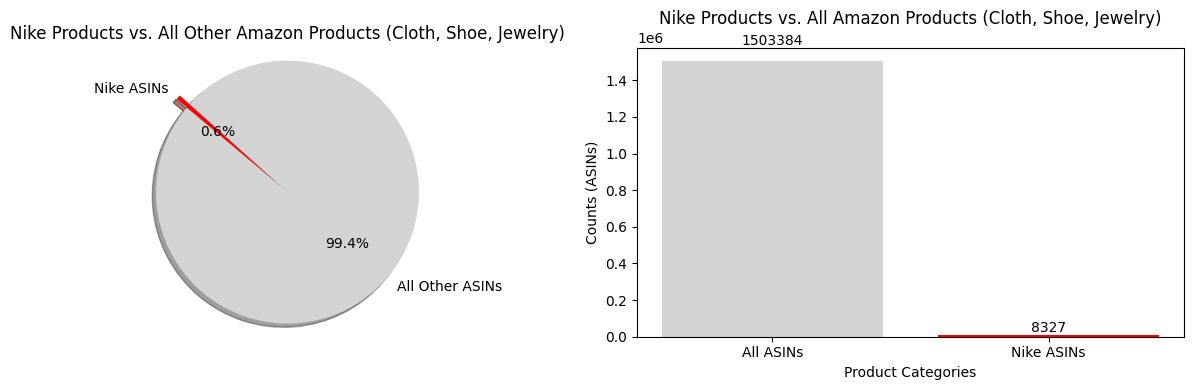

In [ ]:
# Visualize portion and counts of amazon nike products vs. total amazon products for Cloth, shoes, and Jewerly
labelsp = ['All Other ASINs', 'Nike ASINs']
labelsb = ['All ASINs', 'Nike ASINs']
sizes = [len(allasins), len(allnikeasins)]  # Counts of all products and Nike products
colors = ['lightgray','red' ]
explode = (0.1, 0)  # Explode the 'All Other Products' slice for emphasis

plt.figure(figsize=(12, 4))

# Pie Chart
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.pie(sizes, explode=explode, labels=labelsp, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.title('Nike Products vs. All Other Amazon Products (Cloth, Shoe, Jewelry)')

# Bar Chart
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
bars = plt.bar(labelsb, sizes, color=colors)
plt.xlabel('Product Categories')
plt.ylabel('Counts (ASINs)')
plt.title('Nike Products vs. All Amazon Products (Cloth, Shoe, Jewelry)')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05 * yval, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


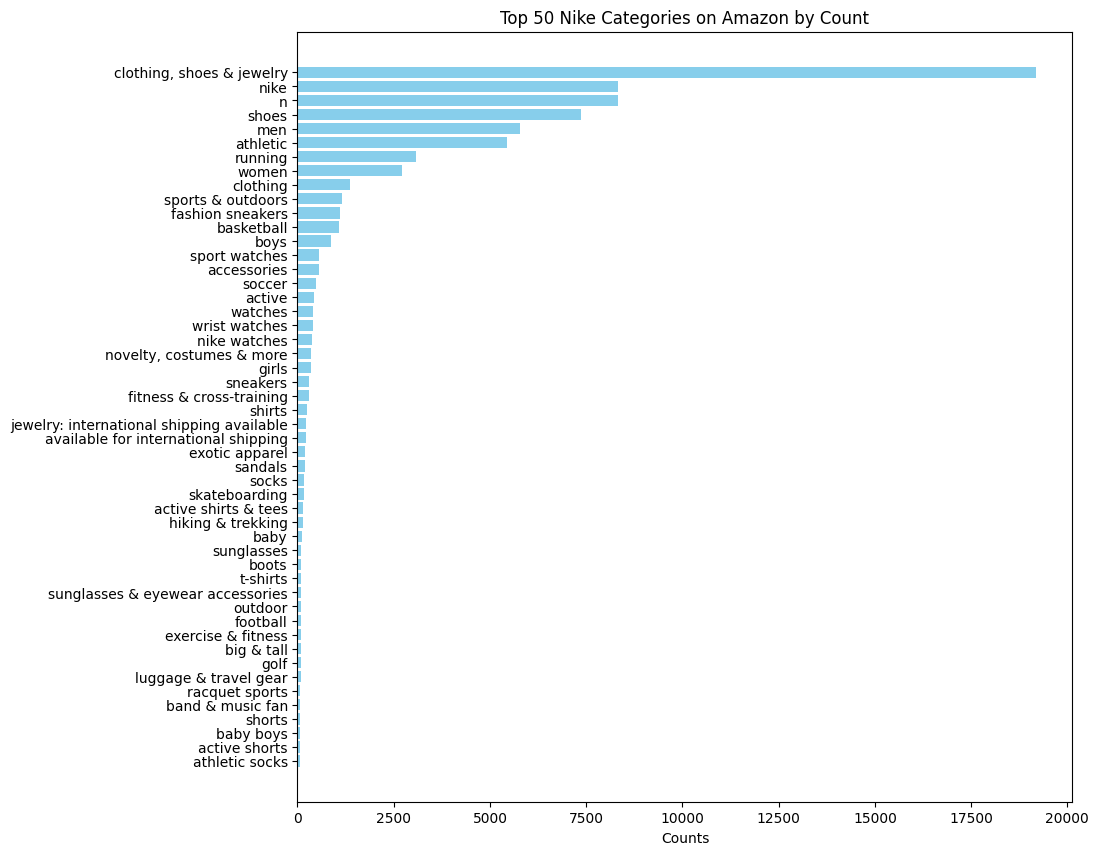

In [ ]:
# Check Nike's top 50 categories items
# sort the categories by count - descending
sortedlist = []
for acategory in allcategories:
  sortedlist.append((allcategories[acategory],acategory))

sortedlist = sorted(sortedlist, reverse=True)

# Plot top 50
top_items = sortedlist[:50]
counts = [item[0] for item in top_items]
categories = [item[1] for item in top_items]

plt.figure(figsize=(10, 10))
plt.barh(categories, counts, color='skyblue')
plt.xlabel('Counts')
plt.title('Top 50 Nike Categories on Amazon by Count')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest counts at the top

plt.show()

In [ ]:
# save ASINS to an output file in Google Drive directory
outputfile = open('%s/allnikeasins.txt' % working_directory, 'w')
outputfile.write(','.join(allnikeasins))
outputfile.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 📈 Taking a look at sales rank
Looking at the data above product example again, recall that there is a "salesRank" key which gives us the product's categorical rank in the format:

```
    { category: rank }
```

We are interested in extracting this rank data in order to produce a data structure of sales ranks by ASIN.

> **SalesRank Dictionart:** We've built a dictionary structure of `ASIN:SalesRank` key-value pairs. The code will be much like the code above to create a list of ASINs, but along the way, you will extract the sales rank and include that information in the data structure.

The sales rank is a bit unusual as a dictionary structure in that it is just a single **key-value pair**. We want to extract this information from the products where it exists, and do so in a way that will not break where it does not. One algorithm for doing this would be:


 - Check that "salesRank" both exists **and** contains information. E.g.:

    ```{"Shoes": 73520}```

 - Convert the `.items()` of the sales rank dictionary into a list for indexing. E.g.:

    ```[("Shoes", 73520)]```

 - Take the 0-index item of the list, which is a (category, rank) tuple. E.g.:

    ```("Shoes", 73520)```

 - Take the 1-index item of that tuple, which is the rank. E.g.:

    ```73520```

## 📊 Sales Ranks distributions
In this case, we want to plot the sales ranks, which is just the values list of the sale_ranks dictionary:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


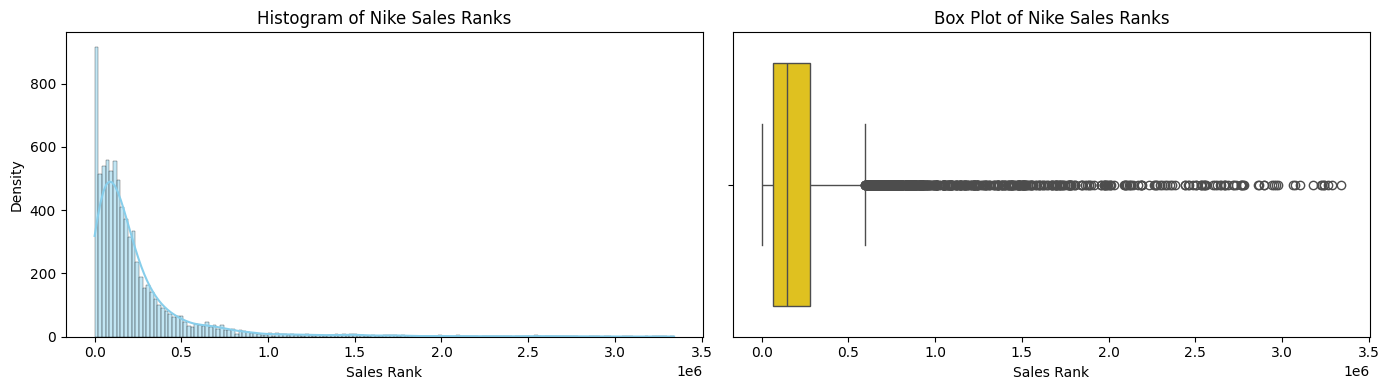

In [ ]:
# histogram and boxplot for Nike products Sales Ranks
sales_rank_values = list(sales_ranks.values())
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Histogram Plot
sns.histplot(sales_rank_values, kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Histogram of Nike Sales Ranks')
ax[0].set_xlabel('Sales Rank')
ax[0].set_ylabel('Density')

# Box Plot
sns.boxplot(x=sales_rank_values, ax=ax[1], color='gold')
ax[1].set_title('Box Plot of Nike Sales Ranks')
ax[1].set_xlabel('Sales Rank')

plt.tight_layout() # avoid overlap
plt.show()


You can see here that there is quite a long tail of low-ranking products, i.e. large values going to the right on the x-axis. Some of these rankings are low enough that Seaborn has plotted at a scale of 1 x 10^6. It looks like our lowest ranking product ranks as about the 3.5 millionth best selling product in it's category!

We can verify this simply by looking at the first and the last item of the ordered list we produced above:

In [ ]:
# sort the sales rank
ordered_asin_ranks = sorted(sales_ranks.items(), key=operator.itemgetter(1))

# best and worst ranks of Nike
print("Best ranking Nike product ASIN and it's rank: ", ordered_asin_ranks[0])

print("\nWorst ranking Nike product ASIN and it's rank: ", ordered_asin_ranks[-1])

Best ranking Nike product ASIN and it's rank:  ('B00EQBFL62', 179)

Worst ranking Nike product ASIN and it's rank:  ('B000AYI6FC', 3341111)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##🚀 Nike's Good Selling Products
At a glance, we can see that the bulk of our ranked products, however, fall into the range of 300,000 (the "box", which has IQR range from 25% to 75%, is under 0.3*1e6 mark in the boxplot above).

It really takes much deeper market analysis to **define a "good selling product"**. But, for this project, let's just assume to define good selling products as the **product ASIN with saleRank < 3000**. So, we will now look at reviews only about those good selling product (based on ASINs).

A few sample best ASINS:  ['B0001LGWEQ', 'B000G42Z2Q', 'B000RDFRIK']
Number of best asins:  274


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


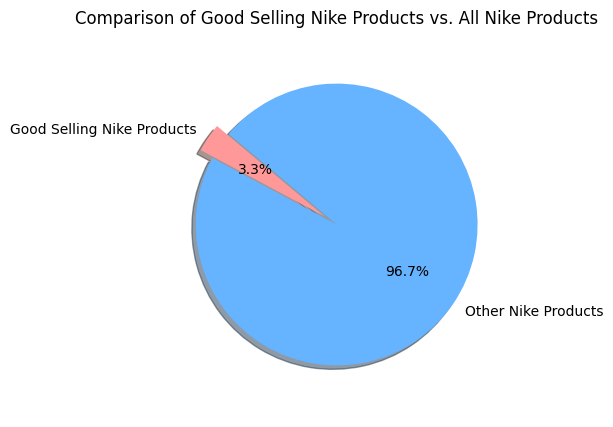

In [ ]:
best_asins = [asin for asin, rank in sales_ranks.items() if rank <= 3000]

# inspect a few best saling items
print("A few sample best ASINS: ", best_asins[:3])
print("Number of best asins: ", len(best_asins))

# pie plot
total_nike_products = len(allnikeasins)
num_best_selling = len(best_asins)
num_other_nike_products = total_nike_products - num_best_selling

labels = ['Good Selling Nike Products', 'Other Nike Products']
sizes = [num_best_selling, num_other_nike_products]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode 1st slice (Good Selling Nike Products)

plt.figure(figsize=(4, 5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Comparison of Good Selling Nike Products vs. All Nike Products')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


# **2. Extract Relevant Nike reviews**


We've extracted ASINs of Nike products on Amazon. From those ASINs, we can easily exact reviews for Nike products.

First, let's **parse all reviews** from data (with are all Amazon reviews for cloth, shoes, the Jewelry)

In [ ]:
# Parse all reviews
#Let's load the review data into a dictionary.

def read_reviews(file_path):
    with gzip.open(file_path, 'rt', encoding='utf-8') as loadedjson:
        count = 0
        for aline in loadedjson:
            count += 1
            if count % 1000000 == 0:
                print(count)
            # Parse the JSON string into a Python dictionary
            areview = json.loads(aline)
            yield count, areview  # Yield the count (as key) and the review object

allreviews = {}

for count, areview in read_reviews(gz_review_path):
    allreviews[count] = areview

print("\nTotal number of all reviews in Amazon: ", len(allreviews))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1000000
2000000
3000000
4000000
5000000

Total number of all reviews in Amazon:  5748920


Now we will **exact reviews for nike** to a **dictionary**. We will use combination of product **ASIN and reviewID** as **keys of the dictionary**.

In [ ]:
# Exact and process Nike reviews - with key as combination of ASIN & reviewerid
def process_reviews(all_nike_reviews, all_nike_asins):
    count = 0
    for areview in all_nike_reviews:
        count += 1
        # if count % 1000000 == 0:
        #     print(count / 5748920)

        # Getting the current review as a dictionary
        thereview = all_nike_reviews[areview]
        theasin = thereview['asin']
        reviewerid = thereview['reviewerID']

        # Exact Nike product
        if theasin in all_nike_asins:
            # key is combination of ASIN and reviewerid
            thekey = '%s.%s' % (theasin, reviewerid)
            yield thekey, thereview  # Yield the key-value pair for the Nike review

nikereviews = {}

for thekey, thereview in process_reviews(allreviews, allnikeasins):
    nikereviews[thekey] = thereview

print("\nTotal number of Nike reviews in Amazon: ", len(nikereviews))

# Save the filtered Nike reviews to a JSON file just in case for used in another notebook
with open(f'{working_directory}/allnikereviews.json', 'w') as json_file:
    json.dump(nikereviews, json_file)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Total number of Nike reviews in Amazon:  21570


##What does a single review in review data look like? ✋

In [ ]:
# Take a look at the dictionary structure of review data
# Just peek into one review record of Nike
key, value = next(iter(nikereviews.items()))

for k,v in value.items():
    print(k,": ",v)

reviewerID :  ACT5DY536GISV
asin :  B0000V9K32
reviewerName :  gaby "gaby"
helpful :  [2, 5]
reviewText :  the colour i received is not blue as shown but yellow.Couldnt change it because it was a birthday present for my daughter and havent got time.She really didn,t like it
overall :  3.0
summary :  not the colour
unixReviewTime :  1248652800
reviewTime :  07 27, 2009


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##🚀 Reviews about good selling Nike products
As a reminder, we've defined those Nike **products with sales rank <=3000**.
In the end, we don't just want the list of products ... we want the product reviews so that we can discover interesting things such as what are customers saying about the good selling products.

In the previous section, we've extracted ASINs about those good selling products. That is, we've stored good selling product asins in "best_asins". Now, we can easilty exact reviews about those products.

In [ ]:
# Get reviews of good selling Nike products (salerank<=3000)

# Exact and process Nike reviews - with key as combination of ASIN & reviewerid
def process_reviews(all_nike_reviews, all_nike_asins):
    """
    A generator function that processes reviews and yields only those related to Nike products.
    """
    count = 0
    for areview in all_nike_reviews:
        count += 1
        # if count % 1000000 == 0:
        #     print(count / 5748920)

        # Getting the current review as a dictionary
        thereview = all_nike_reviews[areview]
        theasin = thereview['asin']
        reviewerid = thereview['reviewerID']

        # Check if the review is for a Nike product
        if theasin in best_asins: # we've stored good selling product asins in "best_asins"
            # Create a unique key for each review
            thekey = '%s.%s' % (theasin, reviewerid)
            yield thekey, thereview  # Yield the key-value pair for the Nike review

# Use the generator to store only Nike reviews
top_nikereviews = {}

# Assuming allreviews is an iterable source like a list, file handler, etc.
for thekey, thereview in process_reviews(allreviews, allnikeasins):
    top_nikereviews[thekey] = thereview


with open(f"{working_directory}/MSDS_Lab1_TopReviews.jsonl", "w") as top_reviews_file:
    for k, v in top_nikereviews.items():
        review = json.dumps(v)
        top_reviews_file.write(f"{review}\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total Amazon reviews for cloth, shoes, and Jewelry: 5748920
Amazon reviews for Nike: 21570
Amazon reviews for Nike Good Selling products (saleRank < 3000): 3549 




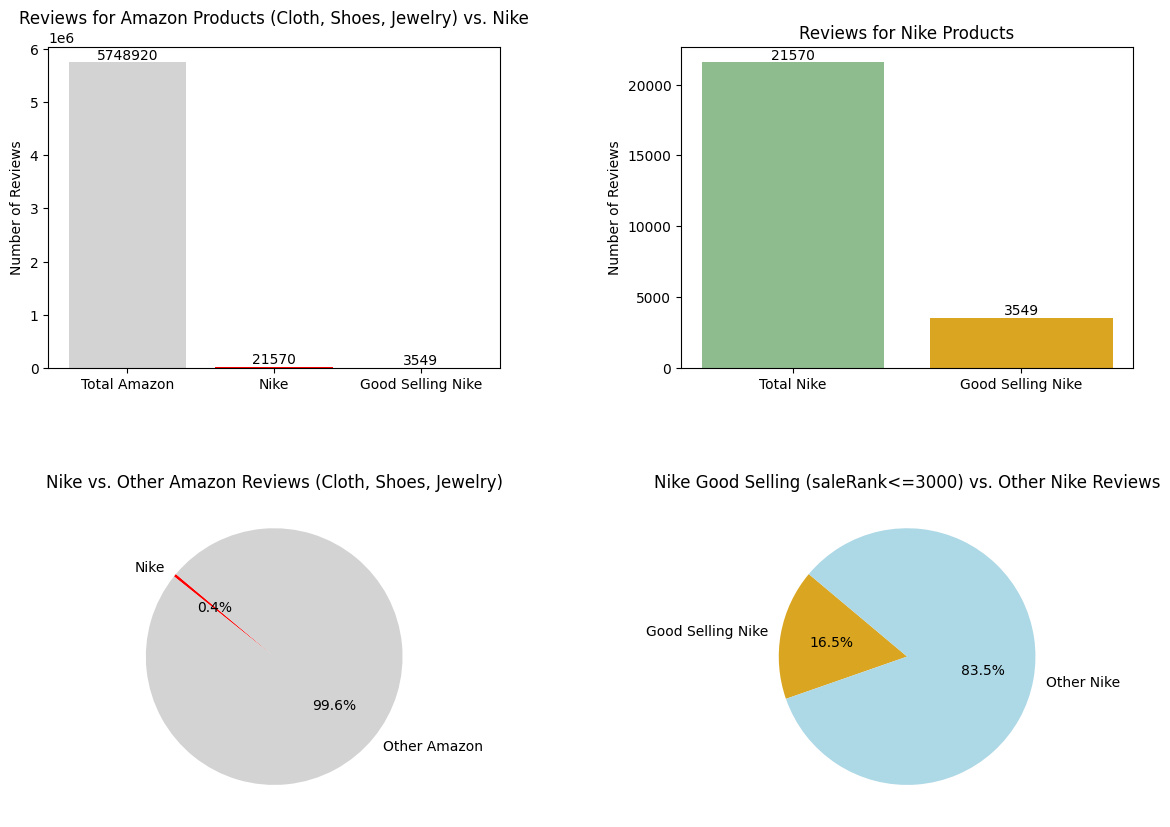

In [ ]:
# Bar charts of total Amazon reviews (cloth,shoes,jewelry), Nike review, and Nike good products reviews(saleRank<3000)
total_reviews = len(allreviews)
total_nike_reviews = len(nikereviews)
total_top_nike_reviews = len(top_nikereviews)

print("Total Amazon reviews for cloth, shoes, and Jewelry:", total_reviews)
print("Amazon reviews for Nike:", total_nike_reviews)
print("Amazon reviews for Nike Good Selling products (saleRank < 3000):", total_top_nike_reviews, "\n\n")

# Data
sizes_all_vs_nike = [total_nike_reviews, total_reviews - total_nike_reviews]
labels_all_vs_nike = ['Nike', 'Other Amazon']
colors_all_vs_nike = ['red', 'lightgray']

sizes_nike_vs_top = [total_top_nike_reviews, total_nike_reviews - total_top_nike_reviews]
labels_nike_vs_top = ['Good Selling Nike', 'Other Nike']
colors_nike_vs_top = ['goldenrod', 'lightblue']

bar_labels = ['Total Amazon', 'Nike', 'Good Selling Nike']
bar_values = [total_reviews, total_nike_reviews, total_top_nike_reviews]
bar_colors = ['lightgray', 'red', 'goldenrod']

# Bar and Pie Plots
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0, 0].bar(bar_labels, bar_values, color=bar_colors)
ax[0, 0].set_title('Reviews for Amazon Products (Cloth, Shoes, Jewelry) vs. Nike')
ax[0, 0].set_ylabel('Number of Reviews')
ax[0, 0].bar_label(ax[0, 0].containers[0], fmt='%d')  # Adding count annotations on the bar chart

ax[1, 0].pie(sizes_all_vs_nike, labels=labels_all_vs_nike, colors=colors_all_vs_nike, autopct='%1.1f%%', startangle=140)
ax[1, 0].set_title('Nike vs. Other Amazon Reviews (Cloth, Shoes, Jewelry)')

ax[0, 1].bar(['Total Nike', 'Good Selling Nike'],
             [total_nike_reviews, total_top_nike_reviews], color=['darkseagreen', 'goldenrod'])
ax[0, 1].set_title('Reviews for Nike Products')
ax[0, 1].set_ylabel('Number of Reviews')
ax[0, 1].bar_label(ax[0, 1].containers[0], fmt='%d')  # Adding count annotations on the bar chart

ax[1, 1].pie(sizes_nike_vs_top, labels=labels_nike_vs_top, colors=colors_nike_vs_top, autopct='%1.1f%%', startangle=140)
ax[1, 1].set_title('Nike Good Selling (saleRank<=3000) vs. Other Nike Reviews')

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


## 😡 Negative Nike Review Texts
As a brand, it's good to look at how many reviews are negative. Let's dive in!

In [ ]:
def get_negative_texts(texts):
    """Implement this function which should take a list of texts
    and returns a list of the texts that are determined to be
    of negative sentiment.

    See the TextBlob documentation for how to evaluate sentiment. For our
    purposes here, negative sentiment is a sentiment with polarity < 0.0.
    """
    negative_texts=[]
    for text in texts:
          if TextBlob(text).sentiment.polarity<0.0:
            negative_texts.append(text)
    return negative_texts


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Get negative Nike reviews
def get_negative_texts(reviews_dict):
    """
    Processes a dictionary of reviews and returns a list of texts with negative sentiment.

    Args:
    reviews_dict (dict): Dictionary where keys are review IDs and values are review dictionaries
                         containing at least a 'reviewText' key.

    Returns:
    List of texts with negative sentiment.
    """
    negative_texts = []
    for review_id, review in reviews_dict.items():
        text = review.get('reviewText', '')  # Extract the review text, default to empty string if not found
        if TextBlob(text).sentiment.polarity < 0.0:
            negative_texts.append(text)
    return negative_texts

negative_nikereviews = get_negative_texts(nikereviews)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of negative Nike reviews: 1966
Total Number of Nike reviews: 21570


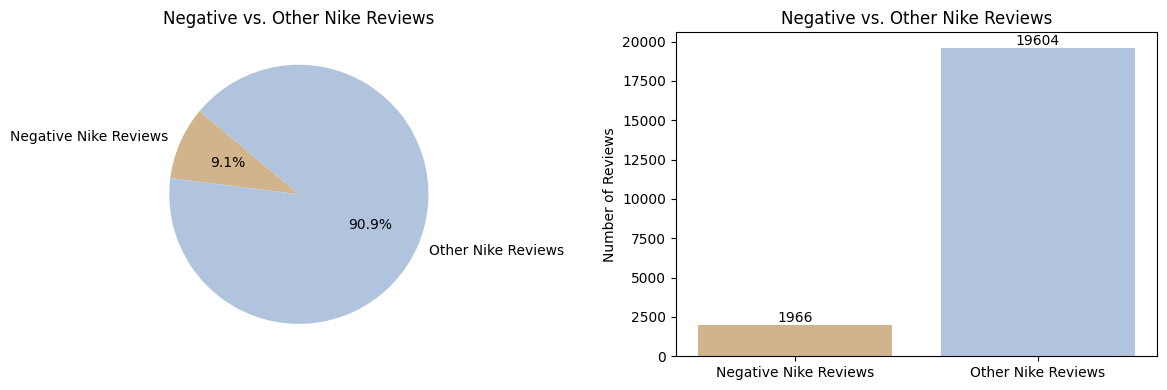

In [ ]:
# Bar and pie charts for Nike negative vs. other reviews
print("Number of negative Nike reviews:", len(negative_nikereviews))
print("Total Number of Nike reviews:", len(nikereviews))

labels = ['Negative Nike Reviews', 'Other Nike Reviews']
sizes = [len(negative_nikereviews), len(nikereviews) - len(negative_nikereviews)]
colors = ['tan', 'lightsteelblue']

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Pie chart
ax[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
ax[0].set_title('Negative vs. Other Nike Reviews')

# Bar Chart
ax[1].bar(labels, sizes, color=colors)
ax[1].set_title('Negative vs. Other Nike Reviews')
ax[1].set_ylabel('Number of Reviews')
ax[1].bar_label(ax[1].containers[0], fmt='%d')  # Adding count annotations on the bar chart

plt.tight_layout()
plt.show()

## 🥸 Take a look at some negative Nike reviews

In [ ]:
# Take a look at a few samples of negative reviews
print("\nSamples of negative reviews: \n")
for i, text in enumerate(negative_nikereviews[:5]):
    print(f"{i+1}. {text}")



Samples of negative reviews: 

1. I'm on my 4th watch... I keep returning it due to poor design.  The band keeps coming apart in the same spot!  Nike hasn't been helpful when I've been in contact with them.  Now, I'm on my 4th watch and something funking is going on with the face of this watch and I've brought it in to a jeweler to have the battery changed.. TWICE and it's still acting up.  I wouldn't purchase another NIKE watch.
2. i had some problems with this order, the bill didn't arrive with the watch to the p.o. box and it couldn't be sent to my country as it was supossed to, when i finally recieved this watch (after sending several emails to solve the situation) it just didn't work, i had to spent money to fix it.
3. Watch was very small and barely fit my 6 year-old daughter's wrist.  And she has a small frame!  Strange.
4. The digital numbers were impossible to see I don't know if there was something wrong with the watch but the glare was terrible.  I sent this watch back.
5. 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



# **3. Text Preprocessing with T&M Toolkit**


 We are going to use tmtoolkit here for text preprocessing. First, we need to use the **corpus functionality** from T&M toolkit. This corpus functionality allows us create a collection of documents that can be easily processed, visualized, and maybe then easily turned into a document term matrix.
 The "corpus" is a special collection of documents in tmtoolkit. - It's not dictionary (although may act a lot like a dictionary), not a list.

 For NLP, we will certainly add "reviewText" field to the corpus. But, we can also combine it with other field for later modeling. For example, ASIN may be very meaningful in clustering topics.

In [ ]:
# Take the reviews from the JSON file, the last line is not a valid review so we slice it out
reviews = {doc_id: nikereviews[doc_id] for doc_id in list(nikereviews)[:-1]}

# Convert reviews to a DataFrame
df_reviews = pd.DataFrame([
    {'doc_id': doc_id, 'reviewText': review_data['reviewText']}
    for doc_id, review_data in reviews.items()
])

# Save the DataFrame to a CSV file
csv_nikereview = '%s/allnikereviews.csv' % working_directory
df_reviews.to_csv(csv_nikereview, index=False)

# Create a new Corpus object
corpus = Corpus(language='en')

# WARNING: This step takes like 5-10 minutes
# Add the CSV file to the corpus using corpus_add_tabular
corpus_add_tabular(corpus, csv_nikereview, id_column='doc_id', text_column='reviewText') # here we only add 'reviewText' to the corpus, but we can also combine it with other fields
print("Total reviews in corpus: ", len(corpus))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2024-09-11 20:48:21,803:INFO:tmtoolkit:creating Corpus instance with no documents
INFO:tmtoolkit:creating Corpus instance with no documents
2024-09-11 20:48:21,805:INFO:tmtoolkit:using serial processing
INFO:tmtoolkit:using serial processing
2024-09-11 20:48:23,026:INFO:tmtoolkit:adding text from 21569 documents(s)
INFO:tmtoolkit:adding text from 21569 documents(s)
2024-09-11 20:48:23,035:INFO:tmtoolkit:running NLP pipeline on 21569 documents
INFO:tmtoolkit:running NLP pipeline on 21569 documents


Total reviews in corpus:  21569


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2024-09-11 20:51:07,685:INFO:tmtoolkit:processing document lengths
INFO:tmtoolkit:processing document lengths
2024-09-11 20:51:07,702:INFO:tmtoolkit:producing plot
INFO:tmtoolkit:producing plot


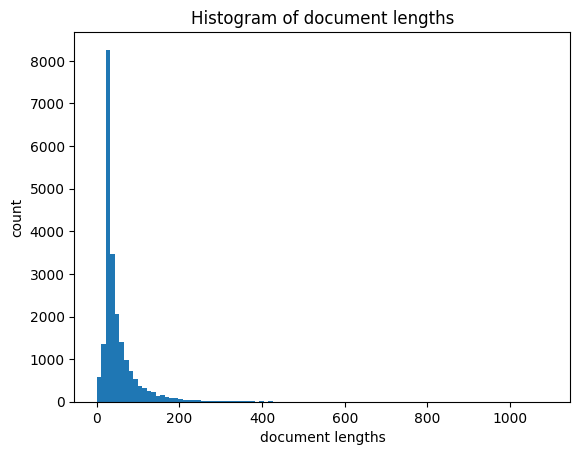

2024-09-11 20:51:08,006:INFO:tmtoolkit:processing vocabulary counts
INFO:tmtoolkit:processing vocabulary counts
2024-09-11 20:51:08,307:INFO:tmtoolkit:producing plot
INFO:tmtoolkit:producing plot


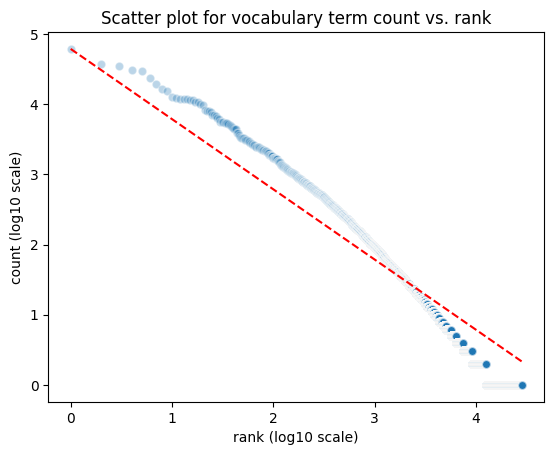

In [ ]:
# Before preprocesse the corpus, let's visualize some statistics about it
# We can compare the plots after preprocessing the text

# Plot the distribution of document lengths (number of tokens per document)
fig, ax = plt.subplots()
plot_doc_lengths_hist(fig, ax, corpus, y_log=False, bins=100)  # Use linear scale on y-axis
plt.show()

# Plot the ranked vocabulary counts (token frequencies)
fig, ax = plt.subplots()
plot_ranked_vocab_counts(fig, ax, corpus, zipf=True)  # Compare with Zipf's law
plt.show()

Now let's do some light **text preprocessing** on the "corpus" we just created with tmtoolkit functions! We will do some more later in dtm in two version of corpus (one with more aggresive preprocessing and one a bit less)
https://tmtoolkit.readthedocs.io/en/latest/preprocessing.html

In [ ]:
# Text Preporcessing
# Transform tokens to lowercase
to_lowercase(corpus)

# Remove punctuation from tokens
remove_punctuation(corpus)

# remove numbers and short tokens
corpus=filter_clean_tokens(corpus, remove_numbers=True, remove_stopwords =True, remove_punct=True, remove_shorter_than=3, inplace=False)

# Lemmatize tokens to get their base form
lemmatize(corpus)

# "nike" isn't informative, remove it
from tmtoolkit.corpus import remove_tokens

tokens_to_remove = ['nike']
remove_tokens(corpus,['nike'])




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2024-09-11 20:51:08,835:INFO:tmtoolkit:replacing 8833 token hashes
INFO:tmtoolkit:replacing 8833 token hashes
2024-09-11 20:51:09,321:INFO:tmtoolkit:replacing 3876 token hashes
INFO:tmtoolkit:replacing 3876 token hashes
2024-09-11 20:51:12,440:INFO:tmtoolkit:creating Corpus instance with no documents
INFO:tmtoolkit:creating Corpus instance with no documents
2024-09-11 20:51:12,442:INFO:tmtoolkit:using serial processing
INFO:tmtoolkit:using serial processing
2024-09-11 20:51:16,287:INFO:tmtoolkit:filtered tokens by mask: num. tokens was 1125385 and is now 408234
INFO:tmtoolkit:filtered tokens by mask: num. tokens was 1125385 and is now 40

## Distribution about Number of words in Nike reviews

**Zipf's law** is an empirical law that suggests a specific distribution of term frequencies in natural language texts. According to Zipf's law, the frequency of any word is inversely proportional to its rank in the frequency table. So the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, and so on.

When you plot ranked vocabulary counts (token frequencies) in a log-log plot, with the ranks on the x-axis and the actual frequencies on the y-axis, Zipf's law predicts a roughly linear relationship. If a corpus follows Zipf's law, you would expect to see a straight line descending from the top-left to the bottom-right of the plot.

Here's what to look for when comparing your corpus with Zipf's law using `plot_ranked_vocab_counts` with the `zipf=True` parameter:

1. **Straight Line on Log-Log Plot**:
   - A straight line on a log-log plot of rank versus frequency indicates that the data follows a power-law distribution, which is consistent with Zipf's law.

2. **Slope of the Line**:
   - The slope of the line in a Zipfian distribution is typically close to -1. Deviations from this slope can indicate that the distribution of word frequencies in your corpus does not perfectly follow Zipf's law.

3. **High-Frequency Words**:
   - The most common words (e.g., "the", "of", "and") should appear at the top-left of the plot, indicating high frequency and low rank.

4. **Long Tail of Low-Frequency Words**:
   - There should be a "long tail" of words that appear infrequently in the corpus. These words will be positioned towards the bottom-right of the plot.

5. **Anomalies or Deviations**:
   - Any significant deviations from the straight line could indicate interesting linguistic features of your corpus. For example, a corpus with a lot of technical jargon or domain-specific language might not follow Zipf's law as closely as a corpus of general English.

It's important to note that while many natural language corpora approximately follow Zipf's law, there are often deviations, especially for smaller corpora or those with specialized vocabulary. The `plot_ranked_vocab_counts` function with `zipf=True` is a tool to help you visualize how closely your corpus follows this law and to identify any interesting patterns or anomalies in your data.

# **4. Generate Document Term Matrix (DTMs)**

We will also now generate two DTMs. This is what's great about TM toolkit, we can do DTMs for **two (or more) sets of corpus** **in parallel** and compare to see results! **bold text**

Let's break down the concepts of document frequency and how the functions `filter_tokens_by_doc_frequency`, `remove_common_tokens`, and `remove_uncommon_tokens` work, along with some examples and heuristic thresholds from academic literature.

Document Frequency (DF)
Document frequency refers to the number of documents in a corpus that contain a specific token (word). For example, if you have a corpus of 100 documents and the word "shoe" appears in 90 of them, the document frequency of "shoe" is 90.

Filtering Tokens by Document Frequency
The function `filter_tokens_by_doc_frequency` allows you to filter out tokens based on how frequently they appear across documents. You can set a threshold to remove tokens that are either too common or too uncommon.

Examples:
1. **Removing Common Tokens**: If you set `df_threshold=0.9`, this means you want to remove tokens that appear in 90% or more of the documents. In our example, "shoe" would be removed because it appears in 90 out of 100 documents.

2. **Removing Uncommon Tokens**: Conversely, if you set `df_threshold=0.1`, you would remove tokens that appear in 10% or fewer of the documents. If "sneaker" appears in only 5 out of 100 documents, it would be removed.

Heuristic Thresholds
In academic literature, there is no one-size-fits-all threshold for document frequency filtering because the optimal threshold can vary depending on the corpus and the goals of the analysis. However, some common heuristics are:

- **Common Tokens**: A threshold of 0.95 to 0.99 is often used to remove extremely common tokens that may not be informative (e.g., stopwords).
- **Uncommon Tokens**: A threshold of 0.01 to 0.05 can be used to remove rare tokens that may be typos, very specific names, or otherwise not useful for broad analysis.

Academic Literature References
- In "Text Mining: Applications and Theory" by Michael W. Berry and Jacob Kogan, thresholds are discussed in the context of term weighting and feature selection.
- "Introduction to Information Retrieval" by Christopher D. Manning, Prabhakar Raghavan, and Hinrich Schütze provides a comprehensive overview of document frequency and its role in information retrieval.

Proportions vs. Absolute Counts
The `df_threshold` parameter can be set as a proportion (e.g., 0.1 for 10%) or as an absolute count (e.g., 10 documents). The choice between using proportions or absolute counts depends on the size of your corpus and your specific use case.

In [ ]:
# we can do some additional preprocessing in this stage
# in this corpus bigger, the additional preprocessing is light
corp_bigger = copy(corpus)
to_lowercase(corp_bigger)

numbers_to_magnitudes(corp_bigger)
table_norm_num = tokens_table(corp_bigger, with_attr='like_num')
table_norm_num[table_norm_num.like_num]

filter_clean_tokens(corp_bigger, remove_shorter_than=2)

remove_common_tokens(corp_bigger, df_threshold=0.98)
remove_uncommon_tokens(corp_bigger, df_threshold=0.001)

print_summary(corp_bigger)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2024-09-11 20:51:22,273:INFO:tmtoolkit:creating Corpus instance with no documents
INFO:tmtoolkit:creating Corpus instance with no documents
2024-09-11 20:51:22,274:INFO:tmtoolkit:using serial processing
INFO:tmtoolkit:using serial processing
2024-09-11 20:51:25,139:INFO:tmtoolkit:replacing 5092 token hashes
INFO:tmtoolkit:replacing 5092 token hashes
2024-09-11 20:51:25,489:INFO:tmtoolkit:replacing 0 token hashes
INFO:tmtoolkit:replacing 0 token hashes
2024-09-11 20:51:29,384:INFO:tmtoolkit:filtered tokens by mask: num. tokens was 407067 and is now 406405
INFO:tmtoolkit:filtered tokens by mask: num. tokens was 407067 and is now 406405
202

Corpus with 21569 documents in English
> allnikereviews-B0000V9KRI.A1BEBWGPSB2DLM (7 tokens): mean rock kinda material lil bit cheap
> allnikereviews-B0000V9K46.A3F8O512N9UNVM (5 tokens): product come promptly describe business
> allnikereviews-B0000V9KRS.A1UY8BIKG0VR12 (13 tokens): arrive dead battery new battery watch order luckil...
> allnikereviews-B0000V9K32.ACT5DY536GISV (12 tokens): colour receive blue show yellow change birthday pr...
> allnikereviews-B0000V9KRI.AR7L2ZP173QEE (12 tokens): good price good material excellent design useful t...
> allnikereviews-B0000V9K3W.A5RZS69KSJH00 (12 tokens): watch exactly order get fast unfortunately bit big...
> allnikereviews-B0000V9KRI.A1EDPEDXSQ78G4 (11 tokens): love watch use day work gym pool sport etc time go...
> allnikereviews-B0000V9KRS.A2RBU58FQTO2MV (9 tokens): totally love watch nice beautiful think buy fair p...
> allnikereviews-B0000V9KNM.A2EAKTCKFRF7A4 (10 tokens): nike make anymore love watch lot compliment questi...
> alln

In [ ]:
# In this small corpus, we will do additional preprocessing more aggresively

corp_smaller = copy(corpus)
to_lowercase(corp_smaller)

numbers_to_magnitudes(corp_smaller)
table_norm_num = tokens_table(corp_smaller, with_attr='like_num')
table_norm_num[table_norm_num.like_num]

filter_clean_tokens(corp_smaller, remove_shorter_than=2)
filter_for_pos(corp_smaller, ['N','V','ADJ']) # In small corpus, keep only noun, verb, and adj.

# remove common and uncommon takens more aggresively
remove_common_tokens(corp_smaller, df_threshold=0.8)
remove_uncommon_tokens(corp_smaller, df_threshold=0.01)

print_summary(corp_smaller)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2024-09-11 20:51:38,846:INFO:tmtoolkit:creating Corpus instance with no documents
INFO:tmtoolkit:creating Corpus instance with no documents
2024-09-11 20:51:38,848:INFO:tmtoolkit:using serial processing
INFO:tmtoolkit:using serial processing
2024-09-11 20:51:41,689:INFO:tmtoolkit:replacing 5092 token hashes
INFO:tmtoolkit:replacing 5092 token hashes
2024-09-11 20:51:41,997:INFO:tmtoolkit:replacing 0 token hashes
INFO:tmtoolkit:replacing 0 token hashes
2024-09-11 20:51:45,841:INFO:tmtoolkit:filtered tokens by mask: num. tokens was 407067 and is now 406405
INFO:tmtoolkit:filtered tokens by mask: num. tokens was 407067 and is now 406405
202

Corpus with 21569 documents in English
> allnikereviews-B0000V9KRI.A1BEBWGPSB2DLM (4 tokens): mean material bit cheap
> allnikereviews-B0000V9K46.A3F8O512N9UNVM (2 tokens): product come
> allnikereviews-B0000V9KRS.A1UY8BIKG0VR12 (9 tokens): arrive new watch order wear watch love style comfy
> allnikereviews-B0000V9K32.ACT5DY536GISV (7 tokens): receive blue show change daughter get time
> allnikereviews-B0000V9KRI.AR7L2ZP173QEE (9 tokens): good price good material excellent design use prod...
> allnikereviews-B0000V9K3W.A5RZS69KSJH00 (8 tokens): watch order get bit big wrist return problem
> allnikereviews-B0000V9KRI.A1EDPEDXSQ78G4 (9 tokens): love watch use day work gym sport time good
> allnikereviews-B0000V9KRS.A2RBU58FQTO2MV (7 tokens): love watch nice beautiful think buy price
> allnikereviews-B0000V9KNM.A2EAKTCKFRF7A4 (8 tokens): nike make love watch lot compliment people like
> allnikereviews-B0000V9K32.A3BVWMS9I8OH8U (7 tokens): cute fit small wrist wear love watch
(and 21559 mo

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


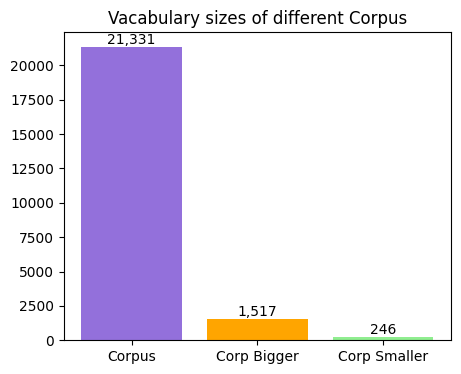

In [ ]:
# Vocabulary sizes of different corpus
labels = ['Corpus', 'Corp Bigger', 'Corp Smaller']
sizes = [vocabulary_size(corpus),vocabulary_size(corp_bigger), vocabulary_size(corp_smaller)]

plt.figure(figsize=(5, 4))
bars = plt.bar(labels, sizes, color=['mediumpurple', 'orange', 'lightgreen'])

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001 * max(sizes),
             f'{bar.get_height():,}', ha='center', va='bottom')
plt.title("Vacabulary sizes of different Corpus")
plt.show()

## What tokens in corpuses look like? 👀

In [ ]:
# Token in light preprocess corpus, a little more preprocessing (big corpus), and aggressive preprocessing (small corpus)
print("Tokens in corpus:         ", corpus[0]['token'])
print("Tokens in bigger corpus:  ", corp_bigger[0]['token'])
print("Tokens in smaller corpus: ", corp_smaller[0]['token'],"\n")

print("Tokens in corpus:         ", corpus[11]['token'])
print("Tokens in bigger corpus:  ", corp_bigger[11]['token'])
print("Tokens in smaller corpus: ", corp_smaller[11]['token'],'\n')

print("Tokens in corpus:         ", corpus[12]['token'])
print("Tokens in bigger corpus:  ", corp_bigger[12]['token'])
print("Tokens in smaller corpus: ", corp_smaller[12]['token'],'\n')

Tokens in corpus:          ['colour', 'receive', 'blue', 'show', 'yellow', 'Couldnt', 'change', 'birthday', 'present', 'daughter', 'get', 'time', 'didn', 'like']
Tokens in bigger corpus:   ['colour', 'receive', 'blue', 'show', 'yellow', 'change', 'birthday', 'present', 'daughter', 'get', 'time', 'like']
Tokens in smaller corpus:  ['receive', 'blue', 'show', 'change', 'daughter', 'get', 'time'] 

Tokens in corpus:          ['good', 'friend', 'watch', 'use', 'work', 'hospital', 'love', 'get', 'use', 'classroom', 'teach', 'cute', 'comfortable', 'watch', 'love']
Tokens in bigger corpus:   ['good', 'friend', 'watch', 'use', 'work', 'hospital', 'love', 'get', 'use', 'cute', 'comfortable', 'watch', 'love']
Tokens in smaller corpus:  ['good', 'friend', 'watch', 'use', 'work', 'love', 'get', 'use', 'cute', 'comfortable', 'watch', 'love'] 

Tokens in corpus:          ['cute', 'work', 'reasonably', 'long', 'cheap', 'gut', 'bad', 'cool', 'look', 'watch']
Tokens in bigger corpus:   ['cute', 'work',

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
token_table_small = tokens_table(corp_smaller,  with_attr=['pos','tag'])
print(token_table_small.shape)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(253276, 5)


In [ ]:
token_table_small[:15]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,doc,position,token,pos,tag
0,allnikereviews-B0000V9K32.A3BVWMS9I8OH8U,0,cute,ADJ,JJ
1,allnikereviews-B0000V9K32.A3BVWMS9I8OH8U,1,fit,VERB,VBZ
2,allnikereviews-B0000V9K32.A3BVWMS9I8OH8U,2,small,ADJ,JJR
3,allnikereviews-B0000V9K32.A3BVWMS9I8OH8U,3,wrist,NOUN,NNS
4,allnikereviews-B0000V9K32.A3BVWMS9I8OH8U,4,wear,VERB,VBP
5,allnikereviews-B0000V9K32.A3BVWMS9I8OH8U,5,love,VERB,VBP
6,allnikereviews-B0000V9K32.A3BVWMS9I8OH8U,6,watch,NOUN,NN
7,allnikereviews-B0000V9K32.ACT5DY536GISV,0,receive,VERB,VBD
8,allnikereviews-B0000V9K32.ACT5DY536GISV,1,blue,ADJ,JJ
9,allnikereviews-B0000V9K32.ACT5DY536GISV,2,show,VERB,VBN


In [ ]:
# save doc dtm, labels, and vacabs
dtm_bg, doc_labels_bg, vocab_bg = dtm(corp_bigger, return_doc_labels=True, return_vocab=True)
dtm_sm, doc_labels_sm, vocab_sm = dtm(corp_smaller, return_doc_labels=True, return_vocab=True)

dtm_bg, dtm_sm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2024-09-11 20:52:00,193:INFO:tmtoolkit:generating sparse DTM with 21569 documents and vocab size 1517
INFO:tmtoolkit:generating sparse DTM with 21569 documents and vocab size 1517
2024-09-11 20:52:07,487:INFO:tmtoolkit:generating sparse DTM with 21569 documents and vocab size 246
INFO:tmtoolkit:generating sparse DTM with 21569 documents and vocab size 246


(<21569x1517 sparse matrix of type '<class 'numpy.int32'>'
 	with 311425 stored elements in Compressed Sparse Row format>,
 <21569x246 sparse matrix of type '<class 'numpy.int32'>'
 	with 212361 stored elements in Compressed Sparse Row format>)

In [ ]:
# save files in drive in case for future use
pickle.dump(doc_labels_bg, open('%s/doc_labels_bg.p' % working_directory, 'wb'))
pickle.dump(doc_labels_sm, open('%s/doc_labels_sm.p' % working_directory, 'wb'))

scipy.sparse.save_npz('%s/small_dtm.npz' % working_directory, dtm_sm) #dtm needs to be saved as scipy.sparse
scipy.sparse.save_npz('%s/big_dtm.npz' % working_directory, dtm_bg)

pickle.dump(vocab_bg, open('%s/big_vocab.p' % working_directory, 'wb'))
pickle.dump(vocab_sm, open('%s/small_vocab.p' % working_directory, 'wb'))

pickle.dump(corpus, open('%s/corpus.p' % working_directory, 'wb') )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# suppress the "INFO" messages and warnings from lda
logger = logging.getLogger('lda')
logger.addHandler(logging.NullHandler())
logger.propagate = False
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **5. Models**

# LDA Model

In LDA topic modeling, serveral key parameters to tune are Alpha and Beta:

- **n_topics**: number of topics or cluster we want. In k-means, this is typically called k.
For tuning, if I see a topic may have some subtopics, maybe I need to increase n_topics. If I see topics are too similar, maybe I need to decrease it so some clusters can merge together. Also, elbow method sometimes helps to find the good number of topics.

- **Alpha** (Document-Topic Density): Controls the **number of topics per document**. How many topics you expect a specified document to be classified with? For example, probably only 1 or 2 topics for each tweets.

For tuning,  **lower Alpha** if documents are assigned **too many topics** (documents classified as too many topics). **Increase Alpha** if documents are assigned **too few topics**.


- **Beta (eta)** (Topic-Word Density): Controls the **number of words per topic**.
For tuning, beta typically start with 0.1. **Lower Beta** if **topics** are too broad (**contain many unrelated words** or too many words associated with a given topic).
Increase Beta if topics are too narrow (contain too few words).


Some [useful article](https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/) to check out.

In [ ]:
# Hyper-parameters
N_TOPICS=16
ETA= .1
N_ITER= 500 # number of iterations to find centroid
ALPHA= 1/16

# set data to use
dtms = {
    'bigger': dtm_bg,
    'smaller': dtm_sm
}

# Here, alpha represents document-topic density - with a higher alpha, documents
# are made up of more topics, and with lower alpha, documents contain fewer topics.
#Beta represents topic-word density - with a high beta, topics are made up of
#most of the words in the corpus, and with a low beta they consist of few words.

lda_params = {
    'n_topics': N_TOPICS,
    'eta': ETA,
    'n_iter': N_ITER,
    'random_state': 20191122,  # to make results reproducible
    'alpha': ALPHA
}

models = compute_models_parallel(dtms, constant_parameters=lda_params)

2024-09-11 20:52:10,432:INFO:tmtoolkit:initializing evaluation with sparse matrix of format `coo` and shape 21569x1517
INFO:tmtoolkit:initializing evaluation with sparse matrix of format `coo` and shape 21569x1517
2024-09-11 20:52:10,560:INFO:tmtoolkit:initializing evaluation with sparse matrix of format `coo` and shape 21569x246
INFO:tmtoolkit:initializing evaluation with sparse matrix of format `coo` and shape 21569x246
2024-09-11 20:52:10,563:INFO:tmtoolkit:init with 2 workers
INFO:tmtoolkit:init with 2 workers
2024-09-11 20:52:10,901:INFO:tmtoolkit:multiproc models: starting with 1 parameter sets on 2 datasets (= 2 tasks) and 2 processes
INFO:tmtoolkit:multiproc models: starting with 1 parameter sets on 2 datasets (= 2 tasks) and 2 processes
2024-09-11 20:52:10,910:INFO:tmtoolkit:fitting LDA model from package "lda" with parameters: {'n_topics': 16, 'eta': 0.1, 'n_iter': 500, 'random_state': 20191122, 'alpha': 0.0625}
2024-09-11 20:52:10,910:INFO:tmtoolkit:fitting LDA model from pa

In [ ]:
model_sm = models['smaller'][0][1]
print_ldamodel_topic_words(model_sm.topic_word_, vocab_sm, top_n=5)

topic_1
> #1. shoe (0.082378)
> #2. color (0.062567)
> #3. look (0.051773)
> #4. black (0.046589)
> #5. white (0.039346)
topic_2
> #1. shoe (0.138848)
> #2. great (0.069306)
> #3. run (0.063330)
> #4. comfortable (0.058380)
> #5. light (0.048239)
topic_3
> #1. great (0.066561)
> #2. shoe (0.055431)
> #3. product (0.041895)
> #4. fit (0.040240)
> #5. time (0.033021)
topic_4
> #1. watch (0.151950)
> #2. time (0.036375)
> #3. look (0.026583)
> #4. band (0.025650)
> #5. work (0.021745)
topic_5
> #1. love (0.096822)
> #2. color (0.086034)
> #3. shoe (0.077055)
> #4. fit (0.062857)
> #5. comfortable (0.058124)
topic_6
> #1. size (0.182427)
> #2. shoe (0.071655)
> #3. small (0.069513)
> #4. order (0.059347)
> #5. fit (0.041325)
topic_7
> #1. shoe (0.078602)
> #2. find (0.062387)
> #3. pair (0.050795)
> #4. size (0.043358)
> #5. love (0.037060)
topic_8
> #1. shoe (0.117739)
> #2. foot (0.093636)
> #3. support (0.035593)
> #4. wear (0.034975)
> #5. walk (0.034615)
topic_9
> #1. shoe (0.131332)


In [ ]:
model_bg = models['bigger'][0][1]
print_ldamodel_topic_words(model_bg.topic_word_, vocab_bg, top_n=5)

topic_1
> #1. wear (0.061094)
> #2. comfortable (0.051855)
> #3. pair (0.050473)
> #4. shoe (0.045077)
> #5. buy (0.028369)
topic_2
> #1. shoe (0.064994)
> #2. nike (0.022597)
> #3. buy (0.022105)
> #4. pair (0.019937)
> #5. wear (0.017638)
topic_3
> #1. shoe (0.071766)
> #2. nike (0.025053)
> #3. like (0.023962)
> #4. feel (0.016177)
> #5. look (0.013770)
topic_4
> #1. color (0.073741)
> #2. shoe (0.063618)
> #3. love (0.059586)
> #4. fit (0.040082)
> #5. comfortable (0.038642)
topic_5
> #1. watch (0.095302)
> #2. time (0.021579)
> #3. band (0.015765)
> #4. like (0.014119)
> #5. look (0.012986)
topic_6
> #1. shoe (0.075303)
> #2. great (0.057624)
> #3. good (0.056009)
> #4. look (0.046275)
> #5. comfortable (0.043961)
topic_7
> #1. shoe (0.095967)
> #2. run (0.064229)
> #3. great (0.020661)
> #4. good (0.019940)
> #5. running (0.019825)
topic_8
> #1. love (0.079139)
> #2. son (0.045948)
> #3. buy (0.044635)
> #4. shoe (0.041072)
> #5. fit (0.031790)
topic_9
> #1. size (0.137172)
> #2.

### 🧐 **DTM size vs. topic modeling performance**
When comparing two topic models with **different document-term matrices** (DTMs)—one with **2,500 words** and another with **500 words**—consider several factors to critically evaluate which topic model is better. Here are some top considerations for inspecting the top words for each topic across the two models:

1. **Coherence and Interpretability**:
   - Check if the top words in each topic form a coherent theme that is **easy to interpret**. A good topic model should produce topics with words that are **semantically related**.
   - A **larger DTM may include more specific or less frequent words** that could potentially lead to more nuanced topics, while a **smaller DTM** may result in **broader topics**.

2. **Distinctiveness of Topics**:
   - **Evaluate whether the topics are distinct from each other** or if there is significant overlap in top words across topics.
   - A model with a **larger DTM** might have **more unique words** that can help **differentiate topics**, but it could also introduce noise. Conversely, a **smaller DTM** might lead to more general topics that could **overlap**.

3. **Relevance of Top Words**:
   - Consider the relevance of the top words to the topics. Are the **top words representative of the topic**, or are they **too general or too obscure**?
   - A **larger DTM** might include more relevant terms for each topic, but it could also **contain irrelevant words** that do not contribute to the topic's meaning.

# ✌🏻**6. Evaluation and Tuning Hyper-parameters**
Now let's use evaluation function in tmtoolkit to see **how various performance statistics change** as we **manipulate those hyper-parameters**.


### ✍️ tmtoolkit evaluation statistics:
- **cao_jun**:

Measures **how distinct or well-separated the topics** are in an LDA model.
It is **to minimize**. A lower cao_jun value indicates better topic separation. Look for the "elbow" point in the plot to find the optimal number of topics.

- **coherence_mino**:

Assesses the **interpretability of topics** by checking **how often the top words in a topic appear together**.
It is **to maximize**. A higher coherence_mino value means more coherent and **meaningful topics**. Look for the peak point in the plot for the best number of topics.

In [ ]:
# constant params
const_params = {'n_iter': 500,'eta': 0.1, 'random_state': 20191122  }

# number of topics
ks = list(range(1, 50, 5))
print(ks)
varying_params = [dict(n_topics=k, alpha=1/k) for k in ks]
print(varying_params)

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46]
[{'n_topics': 1, 'alpha': 1.0}, {'n_topics': 6, 'alpha': 0.16666666666666666}, {'n_topics': 11, 'alpha': 0.09090909090909091}, {'n_topics': 16, 'alpha': 0.0625}, {'n_topics': 21, 'alpha': 0.047619047619047616}, {'n_topics': 26, 'alpha': 0.038461538461538464}, {'n_topics': 31, 'alpha': 0.03225806451612903}, {'n_topics': 36, 'alpha': 0.027777777777777776}, {'n_topics': 41, 'alpha': 0.024390243902439025}, {'n_topics': 46, 'alpha': 0.021739130434782608}]


In [ ]:
eval_results = tm_lda.evaluate_topic_models(dtm_bg,
    varying_params,
    const_params)

2024-09-11 20:52:56,902:INFO:tmtoolkit:initializing evaluation with sparse matrix of format `coo` and shape 21569x1517
INFO:tmtoolkit:initializing evaluation with sparse matrix of format `coo` and shape 21569x1517
2024-09-11 20:52:56,903:INFO:tmtoolkit:init with 8 workers
INFO:tmtoolkit:init with 8 workers
2024-09-11 20:52:58,110:INFO:tmtoolkit:multiproc models: starting with 10 parameter sets on 1 datasets (= 10 tasks) and 8 processes
INFO:tmtoolkit:multiproc models: starting with 10 parameter sets on 1 datasets (= 10 tasks) and 8 processes
2024-09-11 20:52:58,121:INFO:tmtoolkit:fitting LDA model from package "lda" with parameters: {'n_topics': 6, 'alpha': 0.16666666666666666, 'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
2024-09-11 20:52:58,122:INFO:tmtoolkit:fitting LDA model from package "lda" with parameters: {'n_topics': 11, 'alpha': 0.09090909090909091, 'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
2024-09-11 20:52:58,121:INFO:tmtoolkit:fitting LDA model from packa

In [ ]:
from tmtoolkit.topicmod.evaluate import results_by_parameter
results_by_n_topics = results_by_parameter(eval_results, 'n_topics')
print(results_by_n_topics)

[(1, {'cao_juan_2009': nan, 'coherence_mimno_2011': -356.748404603668}), (6, {'cao_juan_2009': 0.47737924369484924, 'coherence_mimno_2011': -406.6327348802096}), (11, {'cao_juan_2009': 0.43390662517111783, 'coherence_mimno_2011': -426.29216751460723}), (16, {'cao_juan_2009': 0.3680078873805806, 'coherence_mimno_2011': -428.4595664093802}), (21, {'cao_juan_2009': 0.3619491749088527, 'coherence_mimno_2011': -429.99873215159687}), (26, {'cao_juan_2009': 0.3586225392818101, 'coherence_mimno_2011': -442.7127686891973}), (31, {'cao_juan_2009': 0.33926066777099234, 'coherence_mimno_2011': -441.6463987326047}), (36, {'cao_juan_2009': 0.3204325770240841, 'coherence_mimno_2011': -449.83150641826893}), (41, {'cao_juan_2009': 0.32690522880977546, 'coherence_mimno_2011': -446.9746127011634}), (46, {'cao_juan_2009': 0.31308553924932386, 'coherence_mimno_2011': -445.88579382855204})]


(<Figure size 600x400 with 2 Axes>,
 [array([<Axes: title={'center': 'cao_juan_2009'}>,
         <Axes: title={'center': 'coherence_mimno_2011'}>], dtype=object)])

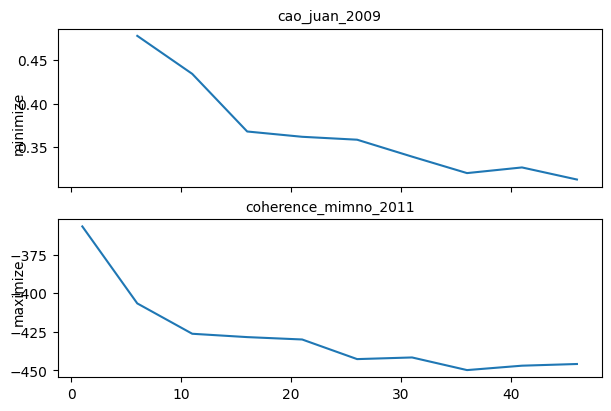

In [ ]:
from tmtoolkit.topicmod.visualize import plot_eval_results
plot_eval_results(results_by_n_topics)

# Eval (lower beta)

In [ ]:
const_params = {'n_iter': 500,'eta': 0.05, 'random_state': 20191122}
varying_params = [dict(n_topics=k, alpha=1/(k)) for k in ks]
print(varying_params)

[{'n_topics': 1, 'alpha': 1.0}, {'n_topics': 6, 'alpha': 0.16666666666666666}, {'n_topics': 11, 'alpha': 0.09090909090909091}, {'n_topics': 16, 'alpha': 0.0625}, {'n_topics': 21, 'alpha': 0.047619047619047616}, {'n_topics': 26, 'alpha': 0.038461538461538464}, {'n_topics': 31, 'alpha': 0.03225806451612903}, {'n_topics': 36, 'alpha': 0.027777777777777776}, {'n_topics': 41, 'alpha': 0.024390243902439025}, {'n_topics': 46, 'alpha': 0.021739130434782608}]


In [ ]:
eval_results = tm_lda.evaluate_topic_models(dtm_bg,
    varying_params,
    const_params)

2024-09-11 20:55:55,562:INFO:tmtoolkit:initializing evaluation with sparse matrix of format `coo` and shape 21569x1517
INFO:tmtoolkit:initializing evaluation with sparse matrix of format `coo` and shape 21569x1517
2024-09-11 20:55:55,566:INFO:tmtoolkit:init with 8 workers
INFO:tmtoolkit:init with 8 workers
2024-09-11 20:55:56,795:INFO:tmtoolkit:multiproc models: starting with 10 parameter sets on 1 datasets (= 10 tasks) and 8 processes
INFO:tmtoolkit:multiproc models: starting with 10 parameter sets on 1 datasets (= 10 tasks) and 8 processes
2024-09-11 20:55:56,805:INFO:tmtoolkit:fitting LDA model from package "lda" with parameters: {'n_topics': 1, 'alpha': 1.0, 'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
2024-09-11 20:55:56,805:INFO:tmtoolkit:fitting LDA model from package "lda" with parameters: {'n_topics': 6, 'alpha': 0.16666666666666666, 'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
2024-09-11 20:55:56,807:INFO:tmtoolkit:fitting LDA model from package "lda" with p

In [ ]:

results_by_n_topics = results_by_parameter(eval_results, 'n_topics')
print(results_by_n_topics)

[(1, {'cao_juan_2009': nan, 'coherence_mimno_2011': -356.748404603668}), (6, {'cao_juan_2009': 0.46891773367103945, 'coherence_mimno_2011': -405.622685365467}), (11, {'cao_juan_2009': 0.42879685515019467, 'coherence_mimno_2011': -411.47616627545483}), (16, {'cao_juan_2009': 0.35533318959948346, 'coherence_mimno_2011': -450.8933242236858}), (21, {'cao_juan_2009': 0.35254177443101437, 'coherence_mimno_2011': -426.3678515678169}), (26, {'cao_juan_2009': 0.33802003405238706, 'coherence_mimno_2011': -436.5460454639817}), (31, {'cao_juan_2009': 0.33074671084345547, 'coherence_mimno_2011': -443.8599507995249}), (36, {'cao_juan_2009': 0.32703615128929103, 'coherence_mimno_2011': -447.2696918981506}), (41, {'cao_juan_2009': 0.3104699839240232, 'coherence_mimno_2011': -439.1377667768211}), (46, {'cao_juan_2009': 0.31033375251767464, 'coherence_mimno_2011': -454.4159938795581})]


(<Figure size 600x400 with 2 Axes>,
 [array([<Axes: title={'center': 'cao_juan_2009'}>,
         <Axes: title={'center': 'coherence_mimno_2011'}>], dtype=object)])

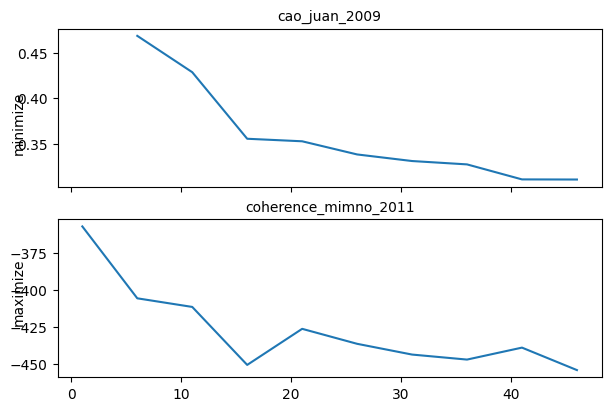

In [ ]:
plot_eval_results(results_by_n_topics)

lower beta from 0.1 to 0.01 doesn't seem to be good. The seration of topics (cao_juan) seems to be worse/bigger.

# Eval (higher beta)

In [ ]:
const_params = {'n_iter': 500,'eta': 0.5, 'random_state': 20191122}
varying_params = [dict(n_topics=k, alpha=1/k) for k in ks]
print(varying_params)

[{'n_topics': 1, 'alpha': 1.0}, {'n_topics': 6, 'alpha': 0.16666666666666666}, {'n_topics': 11, 'alpha': 0.09090909090909091}, {'n_topics': 16, 'alpha': 0.0625}, {'n_topics': 21, 'alpha': 0.047619047619047616}, {'n_topics': 26, 'alpha': 0.038461538461538464}, {'n_topics': 31, 'alpha': 0.03225806451612903}, {'n_topics': 36, 'alpha': 0.027777777777777776}, {'n_topics': 41, 'alpha': 0.024390243902439025}, {'n_topics': 46, 'alpha': 0.021739130434782608}]


In [ ]:
eval_results = tm_lda.evaluate_topic_models(dtm_bg,
    varying_params,
    const_params)

2024-09-11 20:58:47,890:INFO:tmtoolkit:initializing evaluation with sparse matrix of format `coo` and shape 21569x1517
INFO:tmtoolkit:initializing evaluation with sparse matrix of format `coo` and shape 21569x1517
2024-09-11 20:58:47,893:INFO:tmtoolkit:init with 8 workers
INFO:tmtoolkit:init with 8 workers
2024-09-11 20:58:49,109:INFO:tmtoolkit:multiproc models: starting with 10 parameter sets on 1 datasets (= 10 tasks) and 8 processes
INFO:tmtoolkit:multiproc models: starting with 10 parameter sets on 1 datasets (= 10 tasks) and 8 processes
2024-09-11 20:58:49,119:INFO:tmtoolkit:fitting LDA model from package "lda" with parameters: {'n_topics': 6, 'alpha': 0.16666666666666666, 'n_iter': 500, 'eta': 0.5, 'random_state': 20191122}
2024-09-11 20:58:49,118:INFO:tmtoolkit:fitting LDA model from package "lda" with parameters: {'n_topics': 1, 'alpha': 1.0, 'n_iter': 500, 'eta': 0.5, 'random_state': 20191122}
2024-09-11 20:58:49,120:INFO:tmtoolkit:fitting LDA model from package "lda" with par

In [ ]:
results_by_n_topics = results_by_parameter(eval_results, 'n_topics')
print(results_by_n_topics)

[(1, {'cao_juan_2009': nan, 'coherence_mimno_2011': -356.748404603668}), (6, {'cao_juan_2009': 0.4882560419095269, 'coherence_mimno_2011': -398.04368021410716}), (11, {'cao_juan_2009': 0.44951212587234507, 'coherence_mimno_2011': -431.7060788739433}), (16, {'cao_juan_2009': 0.3831222570254655, 'coherence_mimno_2011': -425.9547559164055}), (21, {'cao_juan_2009': 0.37092424016741543, 'coherence_mimno_2011': -416.0151302189973}), (26, {'cao_juan_2009': 0.36900108530930487, 'coherence_mimno_2011': -434.7258567133812}), (31, {'cao_juan_2009': 0.3602755157720359, 'coherence_mimno_2011': -434.8666871906735}), (36, {'cao_juan_2009': 0.3567675038855209, 'coherence_mimno_2011': -437.24449932262763}), (41, {'cao_juan_2009': 0.349902439045492, 'coherence_mimno_2011': -448.4062917833931}), (46, {'cao_juan_2009': 0.34941793525931364, 'coherence_mimno_2011': -435.47245021716986})]


(<Figure size 600x400 with 2 Axes>,
 [array([<Axes: title={'center': 'cao_juan_2009'}>,
         <Axes: title={'center': 'coherence_mimno_2011'}>], dtype=object)])

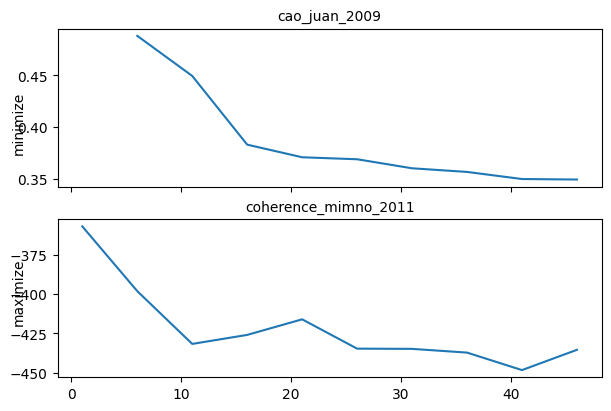

In [ ]:
plot_eval_results(results_by_n_topics)

# Eval (lower alpha)

In [ ]:
const_params = {'n_iter': 500,'eta': 0.1, 'random_state': 20191122}
varying_params = [dict(n_topics=k, alpha=1/(10*k)) for k in ks]
print(varying_params)

[{'n_topics': 1, 'alpha': 0.1}, {'n_topics': 6, 'alpha': 0.016666666666666666}, {'n_topics': 11, 'alpha': 0.00909090909090909}, {'n_topics': 16, 'alpha': 0.00625}, {'n_topics': 21, 'alpha': 0.004761904761904762}, {'n_topics': 26, 'alpha': 0.0038461538461538464}, {'n_topics': 31, 'alpha': 0.0032258064516129032}, {'n_topics': 36, 'alpha': 0.002777777777777778}, {'n_topics': 41, 'alpha': 0.0024390243902439024}, {'n_topics': 46, 'alpha': 0.002173913043478261}]


In [ ]:
eval_results = tm_lda.evaluate_topic_models(dtm_bg,
    varying_params,
    const_params)

2024-09-11 21:01:43,473:INFO:tmtoolkit:initializing evaluation with sparse matrix of format `coo` and shape 21569x1517
INFO:tmtoolkit:initializing evaluation with sparse matrix of format `coo` and shape 21569x1517
2024-09-11 21:01:43,475:INFO:tmtoolkit:init with 8 workers
INFO:tmtoolkit:init with 8 workers
2024-09-11 21:01:44,707:INFO:tmtoolkit:multiproc models: starting with 10 parameter sets on 1 datasets (= 10 tasks) and 8 processes
INFO:tmtoolkit:multiproc models: starting with 10 parameter sets on 1 datasets (= 10 tasks) and 8 processes
2024-09-11 21:01:44,720:INFO:tmtoolkit:fitting LDA model from package "lda" with parameters: {'n_topics': 1, 'alpha': 0.1, 'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
INFO:tmtoolkit:fitting LDA model from package "lda" with parameters: {'n_topics': 1, 'alpha': 0.1, 'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
2024-09-11 21:01:44,723:INFO:tmtoolkit:fitting LDA model from package "lda" with parameters: {'n_topics': 6, 'alpha': 0.0166

In [ ]:

results_by_n_topics = results_by_parameter(eval_results, 'n_topics')
print(results_by_n_topics)

[(1, {'cao_juan_2009': nan, 'coherence_mimno_2011': -356.748404603668}), (6, {'cao_juan_2009': 0.6171996112771454, 'coherence_mimno_2011': -384.20667882285915}), (11, {'cao_juan_2009': 0.5932929284335989, 'coherence_mimno_2011': -407.8472420552825}), (16, {'cao_juan_2009': 0.5518716308972388, 'coherence_mimno_2011': -401.65734632844624}), (21, {'cao_juan_2009': 0.5238615518484967, 'coherence_mimno_2011': -390.69539053515786}), (26, {'cao_juan_2009': 0.525831306171944, 'coherence_mimno_2011': -405.03617192617054}), (31, {'cao_juan_2009': 0.5640636575619803, 'coherence_mimno_2011': -401.21808725824303}), (36, {'cao_juan_2009': 0.5376093152925407, 'coherence_mimno_2011': -397.61627388711565}), (41, {'cao_juan_2009': 0.5253675307096016, 'coherence_mimno_2011': -403.59330051398996}), (46, {'cao_juan_2009': 0.5314092476159662, 'coherence_mimno_2011': -407.80516976713045})]


(<Figure size 600x400 with 2 Axes>,
 [array([<Axes: title={'center': 'cao_juan_2009'}>,
         <Axes: title={'center': 'coherence_mimno_2011'}>], dtype=object)])

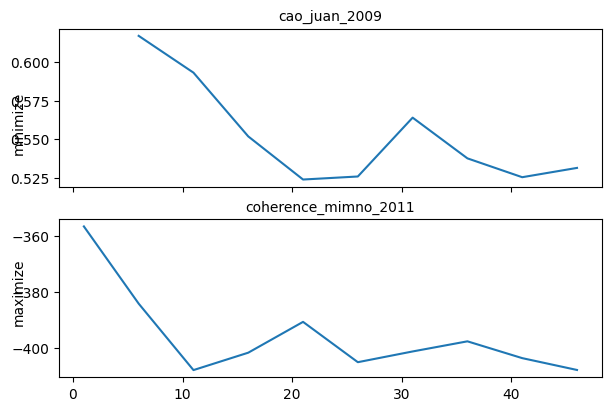

In [ ]:
plot_eval_results(results_by_n_topics)

## Use the best model

It seems when I set eta=0.1, alpha=1/k, and n_topic to be around 31, the statistic matrix look the best. I will use those parameters for my model then.

In [ ]:
# Hyper-parameters
N_TOPICS=31
ETA= .1
N_ITER= 500 # number of iterations to find centroid
ALPHA= 1/N_TOPICS

# set data to use
dtms = {
    'bigger': dtm_bg,
    'smaller': dtm_sm
}


lda_params = {
    'n_topics': N_TOPICS,
    'eta': ETA,
    'n_iter': N_ITER,
    'random_state': 20191122,  # to make results reproducible
    'alpha': ALPHA
}

models_best = compute_models_parallel(dtms, constant_parameters=lda_params)

2024-09-11 21:04:38,428:INFO:tmtoolkit:initializing evaluation with sparse matrix of format `coo` and shape 21569x1517
INFO:tmtoolkit:initializing evaluation with sparse matrix of format `coo` and shape 21569x1517
2024-09-11 21:04:38,549:INFO:tmtoolkit:initializing evaluation with sparse matrix of format `coo` and shape 21569x246
INFO:tmtoolkit:initializing evaluation with sparse matrix of format `coo` and shape 21569x246
2024-09-11 21:04:38,551:INFO:tmtoolkit:init with 2 workers
INFO:tmtoolkit:init with 2 workers
2024-09-11 21:04:38,853:INFO:tmtoolkit:multiproc models: starting with 1 parameter sets on 2 datasets (= 2 tasks) and 2 processes
INFO:tmtoolkit:multiproc models: starting with 1 parameter sets on 2 datasets (= 2 tasks) and 2 processes
2024-09-11 21:04:38,865:INFO:tmtoolkit:fitting LDA model from package "lda" with parameters: {'n_topics': 31, 'eta': 0.1, 'n_iter': 500, 'random_state': 20191122, 'alpha': 0.03225806451612903}
2024-09-11 21:04:38,864:INFO:tmtoolkit:fitting LDA 

In [ ]:
model_best_sm = models_best['smaller'][0][1]
print_ldamodel_topic_words(model_best_sm.topic_word_, vocab_sm, top_n=5)

topic_1
> #1. order (0.069922)
> #2. size (0.065014)
> #3. shoe (0.052325)
> #4. return (0.048973)
> #5. receive (0.031495)
topic_2
> #1. size (0.199189)
> #2. small (0.097728)
> #3. shoe (0.082150)
> #4. order (0.068595)
> #5. run (0.056962)
topic_3
> #1. shoe (0.152732)
> #2. play (0.079479)
> #3. basketball (0.051135)
> #4. great (0.045829)
> #5. good (0.042723)
topic_4
> #1. shoe (0.134663)
> #2. run (0.103246)
> #3. nike (0.048931)
> #4. running (0.030643)
> #5. free (0.029393)
topic_5
> #1. great (0.072867)
> #2. shoe (0.050525)
> #3. product (0.043968)
> #4. time (0.039354)
> #5. arrive (0.035711)
topic_6
> #1. shoe (0.145185)
> #2. run (0.073830)
> #3. comfortable (0.052081)
> #4. good (0.051759)
> #5. great (0.042867)
topic_7
> #1. foot (0.068740)
> #2. boot (0.067592)
> #3. wear (0.065425)
> #4. work (0.064660)
> #5. day (0.059687)
topic_8
> #1. black (0.081040)
> #2. shoe (0.079127)
> #3. white (0.074345)
> #4. color (0.070382)
> #5. look (0.054259)
topic_9
> #1. sandal (0.0

# **😎 Topic Description and Actionable Business Insights**
From the words in each topics, we can get some good sense of what each topics are about and maybe come up with some good **business insights and actions**.

For example:
- Topic 2

Description: Customer dislike running shoes are smaller than expected

Action: Invest if running shoes sizes are correct

- Topic 15

Description: Customers seems to like gym bag in general, but some customers either prefer a small bag size or think the bags are too small (dislike the bag size)

Action: Invest if customers like smaller/bigger gym bags. Accordingly, adjust the bag sizes or add different sizes for different customer needs.

# **7.Topic Names and Classification**

**lambda_** allows you to fine-tune the generation of topic labels:

- Higher values (closer to 1) lead to labels that are more specific to the topic.
- Lower values (closer to 0) result in labels that reflect the most frequent words in the corpus, which might not distinguish between topics as well.

In [ ]:
vocab_sm_array = np.array(vocab_sm)   # we need this to be an array

doc_lengths_sm = doc_lengths(dtm_sm)
topic_labels = generate_topic_labels_from_top_words(
    model_best_sm.topic_word_,
    model_best_sm.doc_topic_,
    doc_lengths_sm,
    vocab_sm_array,
    lambda_=0.8
)

topic_labels

2024-09-11 22:24:09,941:INFO:tmtoolkit:calculating topic-word relevance matrix
INFO:tmtoolkit:calculating topic-word relevance matrix
2024-09-11 22:24:09,946:INFO:tmtoolkit:identifying most relevant words per topic
INFO:tmtoolkit:identifying most relevant words per topic
2024-09-11 22:24:09,951:INFO:tmtoolkit:building topic labels
INFO:tmtoolkit:building topic labels


array(['1_order_return', '2_size_small', '3_shoe_play', '4_run_shoe',
       '5_great_product', '6_shoe_run', '7_boot_work', '8_black_white',
       '9_sandal_comfortable', '10_pair_love', '11_good_product',
       '12_air_sneaker', '13_sock_shirt', '14_shoe_foot', '15_bag_gym',
       '16_son_old', '17_watch_wrist', '18_size_fit', '19_foot_wide',
       '20_great_look', '21_shoe_buy', '22_shoe_pair', '23_love_gift',
       '24_watch_time', '25_little_bit', '26_light_shoe', '27_shoe_great',
       '28_support_shoe', '29_shoe_month', '30_find_size',
       '31_color_love'], dtype='<U20')

In [ ]:
doc_topic = model_best_sm.doc_topic_
doc_labels = pickle.load(open('%s/doc_labels_sm.p' % working_directory, 'rb'))

documentclassifications = ldamodel_top_doc_topics(doc_topic, doc_labels, top_n=2, topic_labels=topic_labels)

In [ ]:
# document_texts = [ ' '.join(corpus[i]['token']) for i in range(len(corpus)) ]
# documentclassifications["text"] = document_texts
documentclassifications.head()

,rank_1,rank_2
document,,
allnikereviews-B0000V9K32.A3BVWMS9I8OH8U,17_watch_wrist (0.754),13_sock_shirt (0.129)
allnikereviews-B0000V9K32.ACT5DY536GISV,31_color_love (0.629),3_shoe_play (0.254)
allnikereviews-B0000V9K3W.A5RZS69KSJH00,17_watch_wrist (0.6703),1_order_return (0.1147)
allnikereviews-B0000V9K46.A3F8O512N9UNVM,21_shoe_buy (0.3441),10_pair_love (0.3441)
allnikereviews-B0000V9KNM.A2EAKTCKFRF7A4,31_color_love (0.448),17_watch_wrist (0.448)


In [ ]:
documentclassifications['text'] = np.nan
for index, arow in documentclassifications.iterrows():
  documentclassifications['text'][index] = corpus[index]

In [ ]:
documentclassifications.to_excel('%s/topics.documentclassification.xlsx' % working_directory)

In [ ]:
# Reload DataFrame
documentclassifications_reload = pd.read_csv('documentclassifications.csv', index_col=0)

In [ ]:
reviews_df = pd.DataFrame.from_dict(nikereviews, orient='index')
reviews_df = reviews_df[['reviewerID', 'asin','reviewText']]
reviews_df.index = 'allnikereviews-' + reviews_df.index
# reviews_df.head(2)

In [ ]:
pd.set_option('display.max_colwidth', None)
review_and_topicRanks =  pd.merge(reviews_df, documentclassifications_reload, left_index=True, right_index=True, how='inner')
review_and_topicRanks.head()


,reviewerID,asin,reviewText,rank_1,rank_2
allnikereviews-B0000V9K32.ACT5DY536GISV,ACT5DY536GISV,B0000V9K32,"the colour i received is not blue as shown but yellow.Couldnt change it because it was a birthday present for my daughter and havent got time.She really didn,t like it",31_color_love (0.629),3_shoe_play (0.254)
allnikereviews-B0000V9K32.A3BVWMS9I8OH8U,A3BVWMS9I8OH8U,B0000V9K32,Very cute and is really practical. Fits better on smaller wrists which is my case. I wear them everywhere. I really love this watch!,17_watch_wrist (0.754),13_sock_shirt (0.129)
allnikereviews-B0000V9K3W.A5RZS69KSJH00,A5RZS69KSJH00,B0000V9K3W,The watch was exactly what i ordered and I got it very fast. Unfortunately it was a bit too big for my wrist. I returned it for a refund without any problems.,17_watch_wrist (0.6703),1_order_return (0.1147)
allnikereviews-B0000V9K46.A3F8O512N9UNVM,A3F8O512N9UNVM,B0000V9K46,"This product came promptly and as described, pleasure doing business with them!-d",21_shoe_buy (0.3441),10_pair_love (0.3441)
allnikereviews-B0000V9KNM.A2EAKTCKFRF7A4,A2EAKTCKFRF7A4,B0000V9KNM,"Why isn't Nike making these anymore? I love this watch, and I get a lot of compliments, questions from people who would like to have one as well.",31_color_love (0.448),17_watch_wrist (0.448)


# Insights from Topic Modeling

## 🤔 Number of reviews and number of ASINs associated with topics we are interested in.

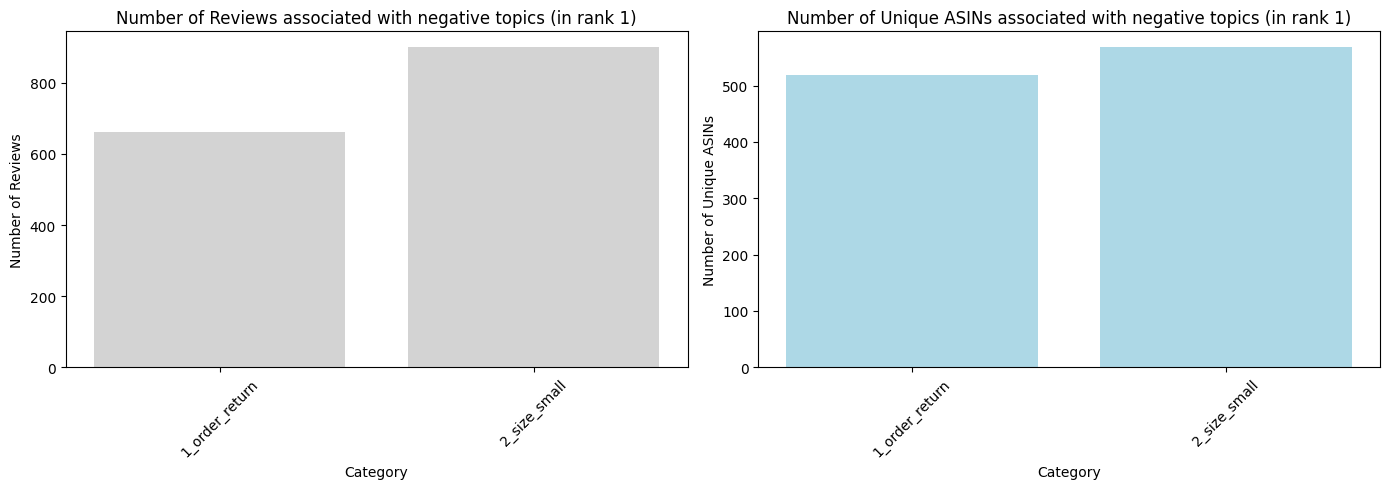

In [ ]:
# List of negative topics review counts and ASIN Counts
dislikes = ['1_order_return', '2_size_small']
review_counts = {}
asin_counts = {}

for category in dislikes:
    count_reviews = review_and_topicRanks['rank_1'].str.contains(category).sum()
    review_counts[category] = count_reviews
    unique_asins = review_and_topicRanks[review_and_topicRanks['rank_1'].str.contains(category)]['asin'].unique()
    asin_counts[category] = len(unique_asins)

df_review_counts = pd.DataFrame(list(review_counts.items()), columns=['Category', 'Number of Reviews'])
df_asin_counts = pd.DataFrame(list(asin_counts.items()), columns=['Category', 'Number of Unique ASINs'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plot
ax[0].bar(df_review_counts['Category'], df_review_counts['Number of Reviews'], color='lightgray')
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Number of Reviews')
ax[0].set_title('Number of Reviews associated with negative topics (in rank 1)')
ax[0].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels

# Plot
ax[1].bar(df_asin_counts['Category'], df_asin_counts['Number of Unique ASINs'], color='lightblue')
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Number of Unique ASINs')
ax[1].set_title('Number of Unique ASINs associated with negative topics (in rank 1)')
ax[1].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

# 🤨 What exactly the reviews look like associated most with the topic of interest?


In [ ]:
# sample reviews with "order return" topic
review_and_topicRanks[review_and_topicRanks['rank_1'].str.contains('1_order_return')].head()

,reviewerID,asin,reviewText,rank_1,rank_2,rank_1_score,rank_2_score
allnikereviews-B0001YMVTS.A1HU5FWBPL98EI,A1HU5FWBPL98EI,B0001YMVTS,"i had some problems with this order, the bill didn't arrive with the watch to the p.o. box and it couldn't be sent to my country as it was supossed to, when i finally recieved this watch (after sending several emails to solve the situation) it just didn't work, i had to spent money to fix it.",1_order_return (0.586),24_watch_time (0.336),0.5860,0.3360
allnikereviews-B0001YMVTS.A1AS3XEPV7EYM4,A1AS3XEPV7EYM4,B0001YMVTS,The product never arrived. The vendor told me it was US postal service issue. The US postal service was of no help. i paid for a product I never received. I won't use Amazon ever again and will advise others the same.,1_order_return (0.8486),13_sock_shirt (0.0794),0.8486,0.0794
allnikereviews-B0006MFAW0.A3TWL3QWHRQ12V,A3TWL3QWHRQ12V,B0006MFAW0,This watch is very cute. It is described as being a petite watch but that is a polite word for saying it is a children's watch. I am not sure why Nike chose to make such a small band width. Even if you are very petite you might want to try to find this in a store to try on before ordering online.,1_order_return (0.502),17_watch_wrist (0.377),0.5020,0.3770
allnikereviews-B0006NGUE6.A3IMJ28EKNX085,A3IMJ28EKNX085,B0006NGUE6,"My husband liked the colors of these shoes, but the width was wrong. Did not have this shoe in a 7 wide, so I ordered him a B width. He said they hurt his feet. Took them to a shoe repair shop and had them stretched twice. Didn't help. Giving them to the Goodwill. It was too late to have them sent back.",1_order_return (0.4137),19_foot_wide (0.4137),0.4137,0.4137
allnikereviews-B0006NGUE6.AYXKUVV8A1GXG,AYXKUVV8A1GXG,B0006NGUE6,"The shoes look good and comfortable. I have worn them for about half a dozen times now. The size is right because I have another Nike Air, so I just ordered the same size as my other Nike Air. The price is right. This is my first pair of golf shoes so I don't want to break the bank.The shipping was slow, though. I purchased it from Amazon. I had to call Amazon's customer service 1 week after I placed the order in order to find out why the item has not been shipped yet. After my call, the item was shipped the next day. I was disappointed with Amazon that the item was not shipped right away. It took about a week to start shipping even though the item was in stock in Amazon's warehouse. It took about 2 weeks to get the item.",1_order_return (0.6882),12_air_sneaker (0.1465),0.6882,0.1465


In [ ]:
# sample reviews with "order return" topic
review_and_topicRanks[review_and_topicRanks['rank_1'].str.contains('2_size_small')].head()

,reviewerID,asin,reviewText,rank_1,rank_2,rank_1_score,rank_2_score
allnikereviews-B0002164KC.AYRYZ0458MNTQ,AYRYZ0458MNTQ,B0002164KC,"By far, the best pair of shoes I've ever owned. Well, you only need to know that their size is normally smaller than normal. You may need to order them bigger in size than you would normally do, e.g, your size is 12, get them 12.5. Anyways, I've been trying to shop for them Worldwide, but I failed to find them. I'd love to buy them in all colors!",2_size_small (0.5516),9_sandal_comfortable (0.2516),0.5516,0.25160
allnikereviews-B0006NGUE6.A22Z9W8U4SUT3A,A22Z9W8U4SUT3A,B0006NGUE6,"a good looking shoe but not to be recommended to buy unseen and untried. For the size on the shoe, it is SMALL and therefore a v tight fit. I would not buy this brand again via the internet",2_size_small (0.5409),31_color_love (0.0794),0.5409,0.07940
allnikereviews-B0006NGUE6.A1GL2RIOBHC40A,A1GL2RIOBHC40A,B0006NGUE6,I bought this shoe for my husband who is normally a 10 1/2 so I got him an 11 just to be safe and they were still kinda tight so my advice is this shoe runs just a bit smaller especially if u have a wider foot,2_size_small (0.4194),23_love_gift (0.2527),0.4194,0.25270
allnikereviews-B0006NGUE6.A3JBMKCMO5PLZL,A3JBMKCMO5PLZL,B0006NGUE6,I only did standard shipping. I ordered on May 1 and they got to the house May 3rd. It&#8217;s a Nike Golf shoe can&#8217;t go wrong and the price was good. I think they may run about a half size small. I don&#8217;t care I will stretch them out. I am not a huge golfer this is more for work functions.,2_size_small (0.5737),24_watch_time (0.1452),0.5737,0.14520
allnikereviews-B0006NGUE6.A5SE11MEAPDSX,A5SE11MEAPDSX,B0006NGUE6,"After finally learning that Nike shoes are always smaller than the listed size, I ordered 1/2 size larger than normal. They are the most como9frtable golf shoes I have ever owned!!",2_size_small (0.7302),29_shoe_month (0.09384),0.7302,0.09384


In [ ]:
# ASINS with "order return" topic as rank 1
filtered_df = review_and_topicRanks[review_and_topicRanks['rank_1'].str.contains( '1_order_return')]
asins_return = set(filtered_df['asin'].tolist())
print("ASINs with topic '1_order_return':", len(asins_return))

# ASINS with "size small" topic as rank 1
filtered_df = review_and_topicRanks[review_and_topicRanks['rank_1'].str.contains( '2_size_small')]
asins_sizeSmall = set(filtered_df['asin'].tolist())
print("ASINs with topic '2_size_small':", len(asins_sizeSmall))


ASINs with topic '1_order_return': 519
ASINs with topic '2_size_small': 568


Number of reviews with '3_shoe_play' in rank_1: 656
Number of reviews with '4_run_shoe' in rank_1: 780
Number of reviews with '5_great_product' in rank_1: 841
Number of reviews with '9_sandal_comfortable' in rank_1: 604
Number of reviews with '10_pair_love' in rank_1: 683
Number of reviews with '11_good_product' in rank_1: 727
Number of reviews with '20_great_look' in rank_1: 702
Number of reviews with '23_love_gift' in rank_1: 850
Number of reviews with '24_watch_time' in rank_1: 601
Number of reviews with '27_shoe_great' in rank_1: 823
Number of reviews with '28_support_shoe' in rank_1: 641
Number of reviews with '31_color_love' in rank_1: 999


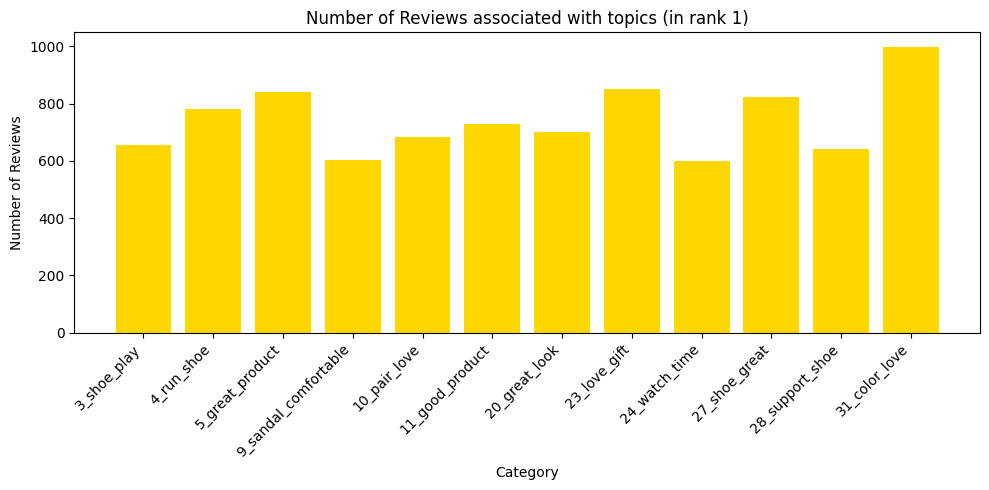

In [ ]:
# Number of reviews with negative postive topics
likes = [ '3_shoe_play', '4_run_shoe', '5_great_product','9_sandal_comfortable', '10_pair_love', '11_good_product', '20_great_look',  '23_love_gift','24_watch_time',  '27_shoe_great', '28_support_shoe',  '31_color_love']

category_counts = {}
for category in likes:
    count = review_and_topicRanks['rank_1'].str.contains(category).sum()
    category_counts[category] = count
    print(f"Number of reviews with '{category}' in rank_1: {count}")

df_counts = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])

plt.figure(figsize=(10, 5))
plt.bar(df_counts['Category'], df_counts['Count'], color='gold')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews associated with topics (in rank 1)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


[pyLDAvis](https://pyldavis.readthedocs.io/en/latest/readme.html) is a Python port of the LDAvis package in R, and is used as a tool for interpreting the topics in a topic model that has been fit to a corpus of text data.

🤠 Please select topic (by either click on a circle on the left or select it in box) to see what words are involved in a specific topic and how much they are involved.

You can also play with lambda in right. As a reminder, **lambda_** allows you to fine-tune the generation of topic labels:

- Higher values (closer to 1) lead to labels that are more specific to the topic.
- Lower values (closer to 0) result in labels that reflect the most frequent words in the corpus, which might not distinguish between topics as well.

In [ ]:
ldavis_params = parameters_for_ldavis(
    model_best_sm.topic_word_,
    model_best_sm.doc_topic_,
    dtm_sm,
    vocab_sm
)

In [ ]:
%matplotlib inline
vis = pyLDAvis.prepare(**ldavis_params)
# vis = pyLDAvis.prepare(**ldavis_params, sort_topics=True)
pyLDAvis.enable_notebook(local=True)
pyLDAvis.display(vis)

# **8. BERT Topic Modeling**

# **Topic Modeling with BERTopic**
taken from: https://github.com/MaartenGr/BERTopic

## BERTopic
BERTopic is a topic modeling technique that leverages 🤗 transformers and a custom class-based TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

<br>

<img src="https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png" width="40%">

For more information, please check out the [BERTopic documentation](https://maartengr.github.io/BERTopic/getting_started/quickstart/quickstart.html#installation).

Also, see the [original tutorial](https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing) from the BERTopic team to go into more depth with things you can do to explore, improve, and make use of your topic model, including:

 * Explore term score decline
 * Update topics for improved topic word representation
 * Topic reduction
 * Topic searching
 * Saving and embedding topic models

# Enabling the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

[Reference](https://colab.research.google.com/notebooks/gpu.ipynb)

### Prepare Review data

In [ ]:
json_path = "%s/allnikereviews.json" % working_directory
json_file = json.load(open(json_path, 'r'))

allreviewtext = []
for areview in json_file:
  allreviewtext.append(json_file[areview]['reviewText'])

print("sample review: ", allreviewtext[0])
print("Number of nike reviews: ", len(allreviewtext))

sample review:  the colour i received is not blue as shown but yellow.Couldnt change it because it was a birthday present for my daughter and havent got time.She really didn,t like it
Number of nike reviews:  21570


#### Do some text preprocessing

In [ ]:
# Preprocess text data
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove punctuation
    tokens = [token for token in tokens if token.isalpha()]

    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

preprocessed_reviews = [preprocess_text(review) for review in allreviewtext]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Topic Modeling**

In this example, we will go through the main components of BERTopic and the steps necessary to create a strong topic model.


## Training

We start by instantiating BERTopic. We set language to `english` since our documents are in the English language. If you would like to use a multi-lingual model, please use `language="multilingual"` instead.

We will also calculate the topic probabilities. However, this can slow down BERTopic significantly at large amounts of data (>100_000 documents). It is advised to turn this off if you want to speed up the model.


In [ ]:
# BERTopic modeling
topic_model = BERTopic(
    language="english",
    calculate_probabilities=True,
    verbose=True,
)
# topics, probs = topic_model.fit_transform(allreviewtext)
topics, probs = topic_model.fit_transform(preprocessed_reviews)
# topics, probs = topic_model.fit_transform(corp_smaller)


2024-09-11 21:06:29,895 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/675 [00:00<?, ?it/s]

2024-09-11 21:06:42,094 - BERTopic - Embedding - Completed ✓
2024-09-11 21:06:42,096 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-11 21:07:12,326 - BERTopic - Dimensionality - Completed ✓
2024-09-11 21:07:12,328 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-11 21:07:41,484 - BERTopic - Cluster - Completed ✓
2024-09-11 21:07:41,494 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-11 21:07:42,042 - BERTopic - Representation - Completed ✓


**NOTE**: Use `language="multilingual"` to select a model that support 50+ languages.

## Extracting Topics
After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents.

In [ ]:
freq = topic_model.get_topic_info(); freq.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,8556,-1_shoe_foot_nike_pair,"[shoe, foot, nike, pair, size, comfortable, co...",[looking around found product think overrated ...
1,0,1139,0_watch_band_wrist_battery,"[watch, band, wrist, battery, button, feature,...",[watch little year yesterday wrist band actual...
2,1,754,1_son_grandson_old_kid,"[son, grandson, old, kid, boy, love, school, s...",[son shoe great shoe school year problem fit g...
3,2,729,2_fit_size_perfect_expected,"[fit, size, perfect, expected, small, tight, p...","[fit great, fit great, love fit perfect look g..."
4,3,724,3_sock_crew_foot_dry,"[sock, crew, foot, dry, wear, stay, fit, wash,...",[good sock normal nike sock expect nike sock b...


-1 refers to all outliers and should typically be ignored. Next, let's take a look at a frequent topic that were generated:

In [ ]:
topic_model.get_topic(0)  # Select the most frequent topic

[('watch', 0.05156114719887938),
 ('band', 0.02032135989950255),
 ('wrist', 0.019404019965536402),
 ('battery', 0.015919886448592678),
 ('button', 0.013089042866376755),
 ('feature', 0.011882210313272096),
 ('display', 0.011507928834276673),
 ('easy', 0.010959511403227018),
 ('face', 0.010955760496942997),
 ('function', 0.010107479947094693)]

**NOTE**: BERTopic is stocastic which mmeans that the topics might differ across runs. This is mostly due to the stocastisc nature of UMAP.

# **Visualization**
There are several visualization options available in BERTopic, namely the visualization of topics, probabilities and topics over time. Topic modeling is, to a certain extent, quite subjective. Visualizations help understand the topics that were created.

In [ ]:
topic_model.visualize_topics()

## Visualize Topic Hierarchy

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. This might help selecting an appropriate nr_topics when reducing the number of topics that you have created.

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

## Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [ ]:
topic_model.visualize_barchart(top_n_topics=20)

## Visualize Topic Similarity
Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [ ]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

## Visualize Term Score Decline
Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, the select the best number of words in a topic.


In [ ]:
topic_model.visualize_term_rank()

# **Topic Representation**
After having created the topic model, you might not be satisfied with some of the parameters you have chosen. Fortunately, BERTopic allows you to update the topics after they have been created.

This allows for fine-tuning the model to your specifications and wishes.

## Update Topics
When you have trained a model and viewed the topics and the words that represent them,
you might not be satisfied with the representation. Perhaps you forgot to remove
stopwords or you want to try out a different `n_gram_range`. We can use the function `update_topics` to update
the topic representation with new parameters for `c-TF-IDF`:

In [ ]:
# topic_model.update_topics(allreviewtext, topics, n_gram_range=(1, 2))
topic_model.update_topics(preprocessed_reviews, topics, n_gram_range=(1, 2))
topic_model.get_topic(0)   # We select topic that we viewed before

[('watch', 0.03999588887723948),
 ('band', 0.013229144421267684),
 ('wrist', 0.012348678917953425),
 ('battery', 0.009919046294608762),
 ('button', 0.008058308849966464),
 ('feature', 0.007477509153286822),
 ('easy', 0.007421649686422083),
 ('time', 0.007314058865847367),
 ('display', 0.007033746814913552),
 ('face', 0.006860211592867158)]

## Topic Reduction
We can also reduce the number of topics after having trained a BERTopic model. The advantage of doing so,
is that you can decide the number of topics after knowing how many are actually created. It is difficult to
predict before training your model how many topics that are in your documents and how many will be extracted.
Instead, we can decide afterwards how many topics seems realistic:

In [ ]:
similar_topics, similarity = topic_model.find_topics("vehicle", top_n=5); similar_topics

[15, 25, 44, 4, 6]

In [ ]:
topic_model.get_topic(71)

[('item', 0.057209868559820944),
 ('address', 0.0298819294240008),
 ('received', 0.028337244584394617),
 ('send', 0.023891916563975137),
 ('never received', 0.01905637895595604),
 ('back', 0.016951525251521916),
 ('company', 0.01686640447209427),
 ('service', 0.016312290889858493),
 ('wrong item', 0.015779406921579142),
 ('postal', 0.015300560997057108)]

# **Model serialization**
The model and its internal settings can easily be saved. Note that the documents and embeddings will not be saved. However, UMAP and HDBSCAN will be saved.

In [ ]:
# Save model
topic_model.save("%s/my_model" % working_directory)

2024-09-11 21:07:49,774 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
# Load model
my_model = BERTopic.load("%s/my_model" % working_directory)

In [ ]:
topic_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")